In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

import arviz as az

import stan

from jax import jacobian
from jax.experimental.ode import odeint
import jax.numpy as jnp

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin, thin_gf

from mcmc import sample_chain, metropolis_random_walk_step, rw_proposal_sampler
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.plotting import highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = Path('../report') / 'figures'

Directory where results of expensive calculations will be stored:

In [6]:
generated_data_dir = Path('../data') / 'generated'
utils.caching.cache_dir = generated_data_dir

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35635,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:35547,Total threads: 4
Dashboard: http://127.0.0.1:39463/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:39137,


In [9]:
map_parallel = get_map_parallel(client)

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_2$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

Define the Lotka-Volterra model:

In [10]:
def lotka_volterra(t, u, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2 = u
    return [
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
    ]

Solve the coupled ODEs:

In [11]:
t_n = 2400  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1., 1.]  # parameters of the model
q = 2  # number of state variables
d = len(theta)  # dimension of the parameter space
u_init = [1., 1.]  # initial values

In [12]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [13]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [14]:
rng = np.random.default_rng(12345)

In [15]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [16]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

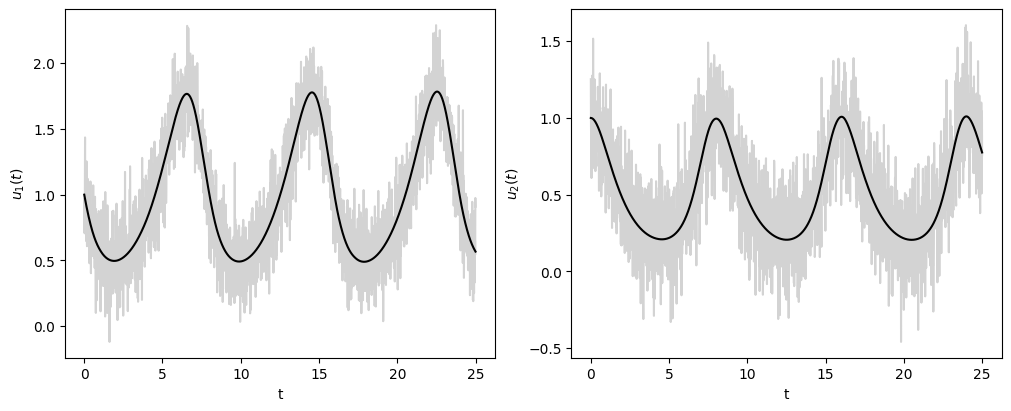

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
#fig.suptitle('Lotka-Volterra solution with added Gaussian noise');
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

fig.savefig(figures_path / 'lotka-volterra.pdf');

In [18]:
if save_data:
    filepath = generated_data_dir / 'lotka_volterra_gaussian_noise.csv'
    df = pd.DataFrame({'u1': y[:, 0], 'u2': y[:, 1]}, index=pd.Index(t, name='t'))
    df.to_csv(filepath)

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [19]:
def log_target_density(log_theta):
    _, u = solve_lotka_volterra(np.exp(log_theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(log_theta))
    return log_likelihood + log_prior

In [20]:
n_samples_rw = 500_000

In [21]:
# TODO consider selecting step size automatically following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.0025

We use the initial values from Table S3 in Supplementary Material:

In [22]:
theta_inits = [
    np.array([0.55, 1, 0.8, 0.8]),
    np.array([1.5, 1., 0.8, 0.8]),
    np.array([1.3, 1.33, 0.5, 0.8]),
    np.array([0.55, 3., 3., 0.8]),
    np.array([0.55, 1., 1.5, 1.5]),
]

In [23]:
rw_seed = 12345
def run_rw_sampler(theta_init):
    rng = np.random.default_rng(rw_seed)
    theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size, rng, d), rng)
    return sample_chain(theta_sampler, np.log(theta_init), n_samples_rw)

In [24]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_samples() -> list[np.ndarray]:
    return map_parallel(run_rw_sampler, theta_inits)

In [25]:
# force calculation in parallel
rw_samples[0];

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading ../data/generated/rw_samples_0.npy


Reproduce the first column in Figure S17 from the Supplementary Material:

In [26]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(d)]

DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading ../data/generated/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading ../data/generated/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.caching:Reading ../data/generated/rw_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_4
DEBUG:utils.caching:Reading ../data/generated/rw_samples_4.npy


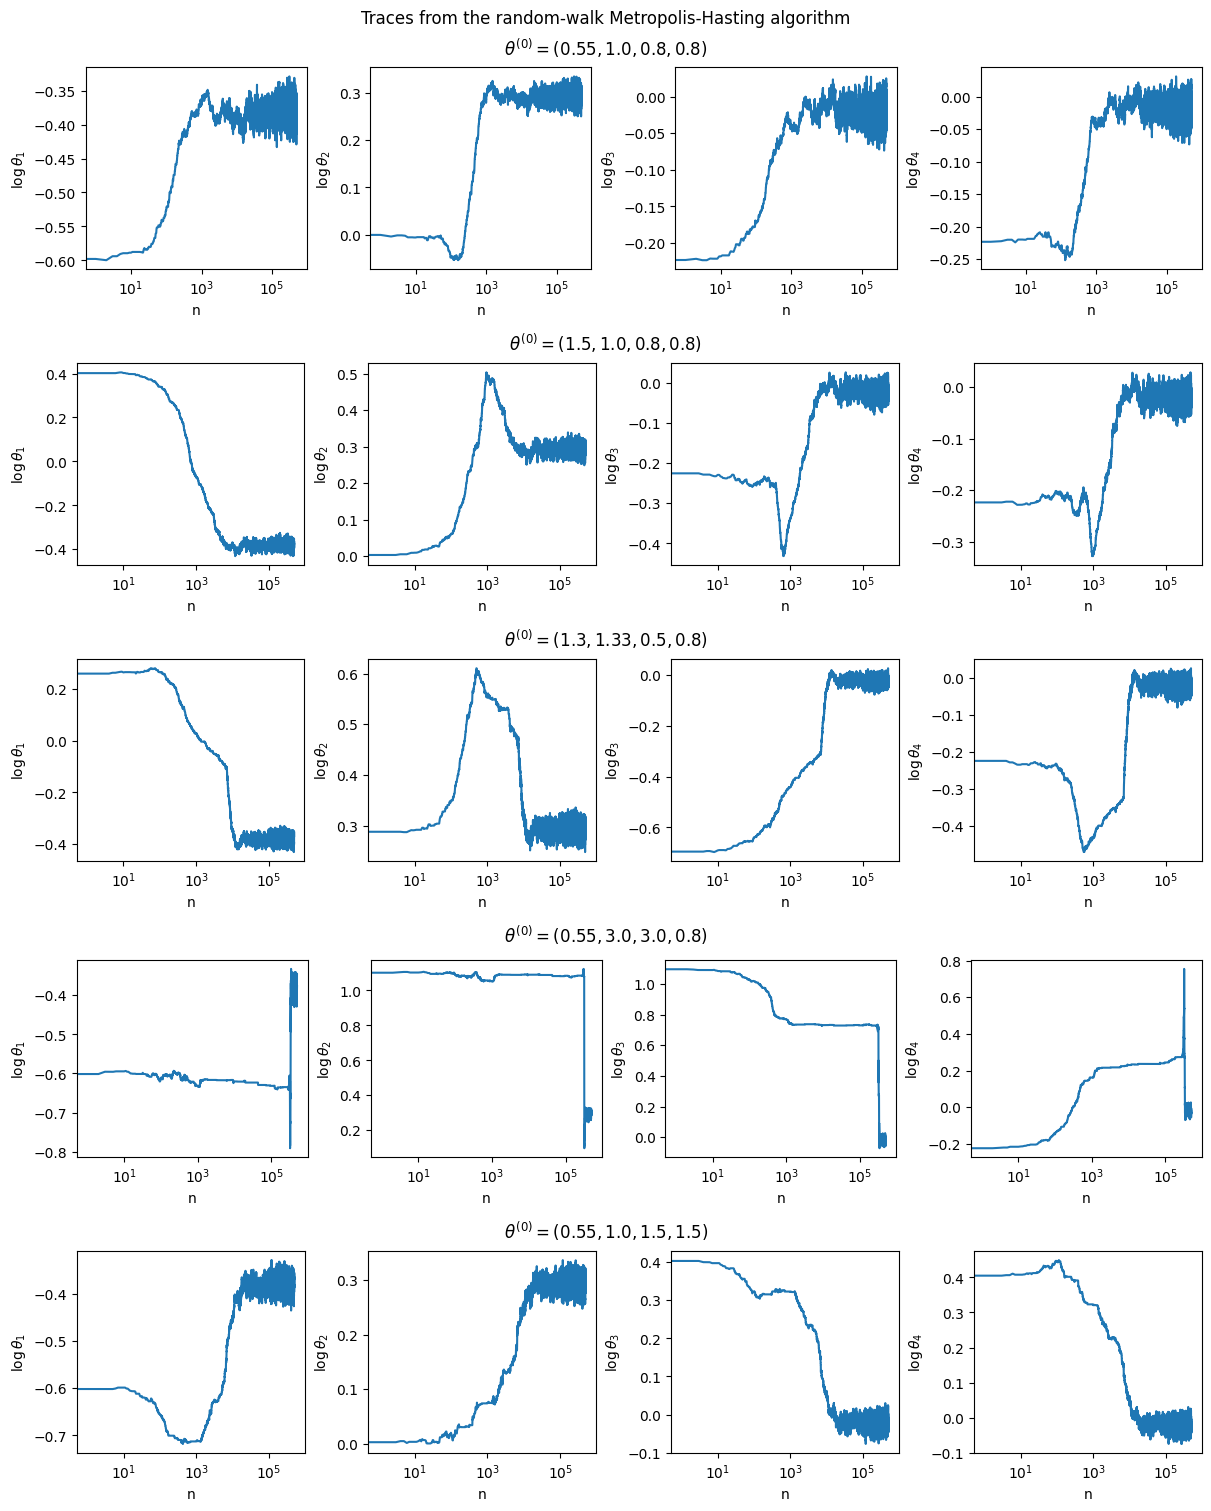

In [27]:
fig = plot_traces(rw_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the random-walk Metropolis-Hasting algorithm');

Produce a figure for the report:

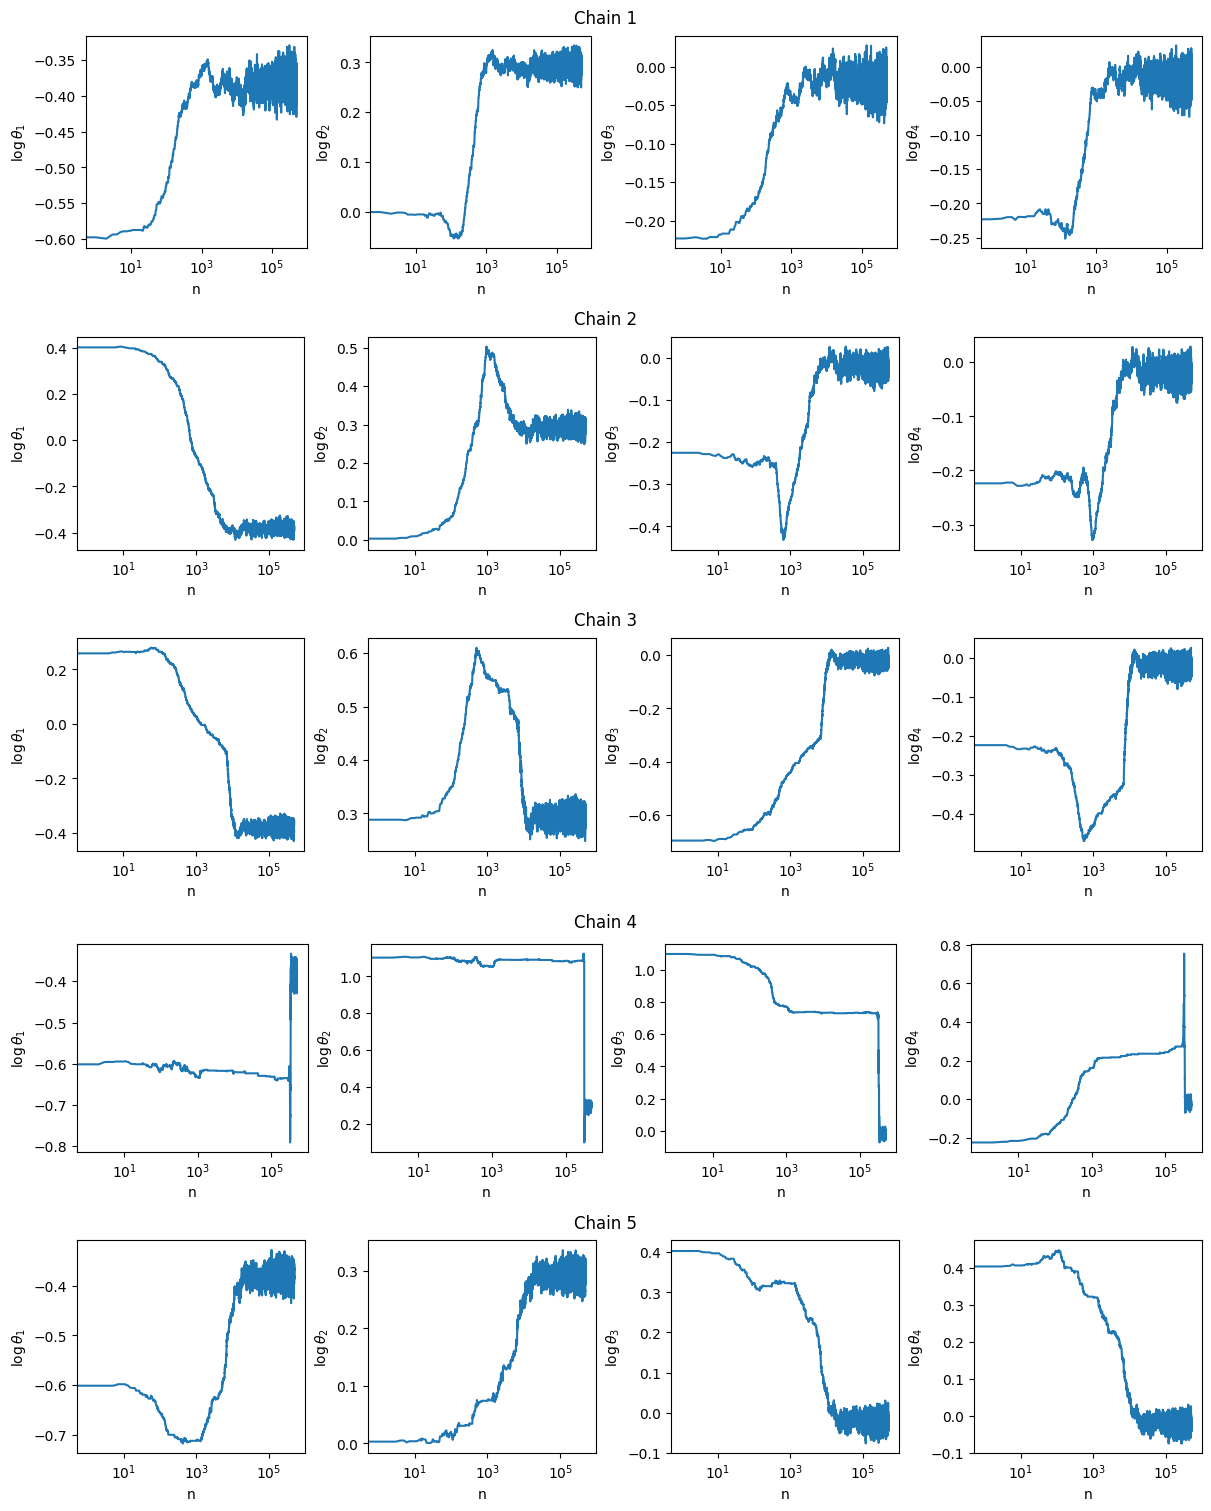

In [28]:
fig = plot_traces(rw_samples, titles=[f'Chain {i + 1}' for i in range(len(rw_samples))], var_labels=var_labels);
fig.savefig(figures_path / 'lotka-volterra-trace-plots.pdf');

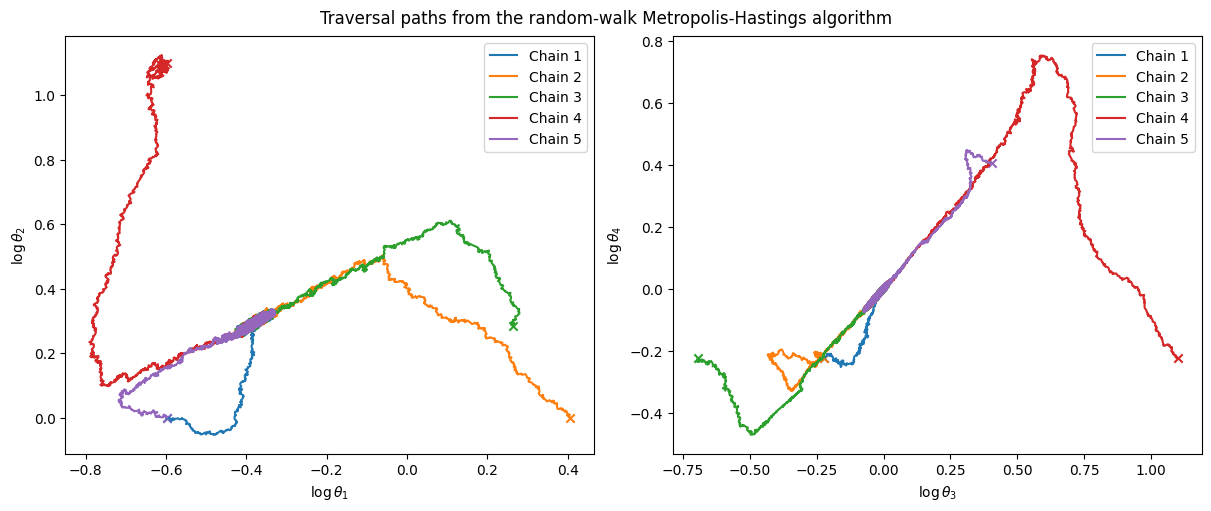

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plot_paths(rw_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(rw_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');
fig.savefig(figures_path / 'lotka-volterra-chain-paths.png', dpi=600);
fig.suptitle('Traversal paths from the random-walk Metropolis-Hastings algorithm');

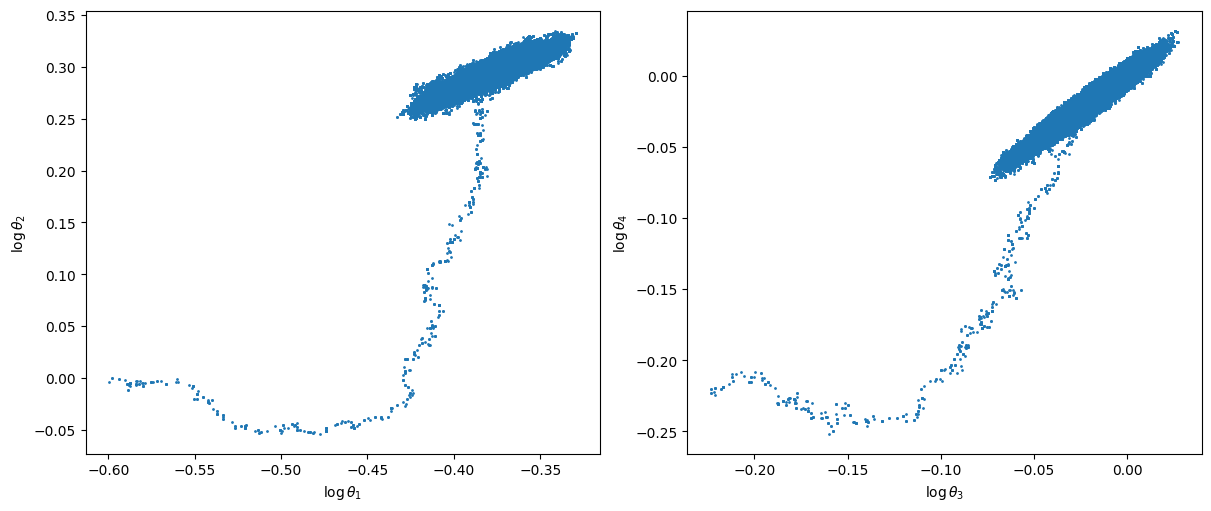

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True);
highlight_points(rw_samples[0], [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None, sample_point_alpha=1.);
fig.savefig(figures_path / 'lotka-volterra-chain1-sample.png', dpi=300);

In [30]:
def acceptance_rate(sample):
    """Fraction of accepted samples"""
    return (np.sum(np.any(sample[1:] != sample[:-1], axis=1)) + 1) / sample.shape[0]

In [31]:
[acceptance_rate(sample) for sample in rw_samples]

[0.2306775386449227,
 0.23022353955292088,
 0.22811954376091248,
 0.07851784296431408,
 0.22772154455691088]

## Convergence diagnostics

``arviz`` implements $\hat{R}$ and the expected sample size as recommended in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_. The paper suggests the minimum ESS of 50 for each chain and the threshold value of 1.01 for $\hat{R}$. Based on these thresholds, the chains would be deemed not to have converged:

In [32]:
@cached(recalculate=recalculate, persist=True)
def rw_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(rw_samples, var_names=[f'log_theta{i + 1}' for i in range(d)]))

In [33]:
rw_az_summary()

DEBUG:utils.caching:Reading from disk cache: rw_az_summary
DEBUG:utils.caching:Reading ../data/generated/rw_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta1,-0.416,0.091,-0.636,-0.355,0.035,0.026,16.0,19.0,1.23
log_theta2,0.394,0.267,0.270,1.085,0.108,0.080,17.0,31.0,1.23
log_theta3,0.078,0.254,-0.044,0.736,0.103,0.077,14.0,13.0,1.28
log_theta4,0.020,0.105,-0.045,0.273,0.038,0.028,17.0,39.0,1.21


# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [34]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector log_theta) {
    vector[2] dudt;
    dudt[1] = exp(log_theta[1]) * u[1] - exp(log_theta[2]) * u[1] * u[2];
    dudt[2] = exp(log_theta[4]) * u[1] * u[2] - exp(log_theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] log_theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, log_theta);
  log_theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [35]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [36]:
n_samples_hmc = 10_000

In [37]:
def extract_chains(stan_sample, param):
    """Extract chains from PyStan fit"""
    param_indices = stan_sample._parameter_indexes(param)
    return [stan_sample._draws[param_indices, :, i_chain].T for i_chain in range(stan_sample.num_chains)]

In [38]:
hmc_seed = 12345

In [39]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=True,
        init=[{'log_theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'log_theta')

In [40]:
# force the calculation
hmc_samples[0];

DEBUG:utils.caching:Reading from disk cache: hmc_samples_0
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_0.npy


DEBUG:utils.caching:Reading from disk cache: hmc_samples_1
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_2
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_3
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_samples_4
DEBUG:utils.caching:Reading ../data/generated/hmc_samples_4.npy


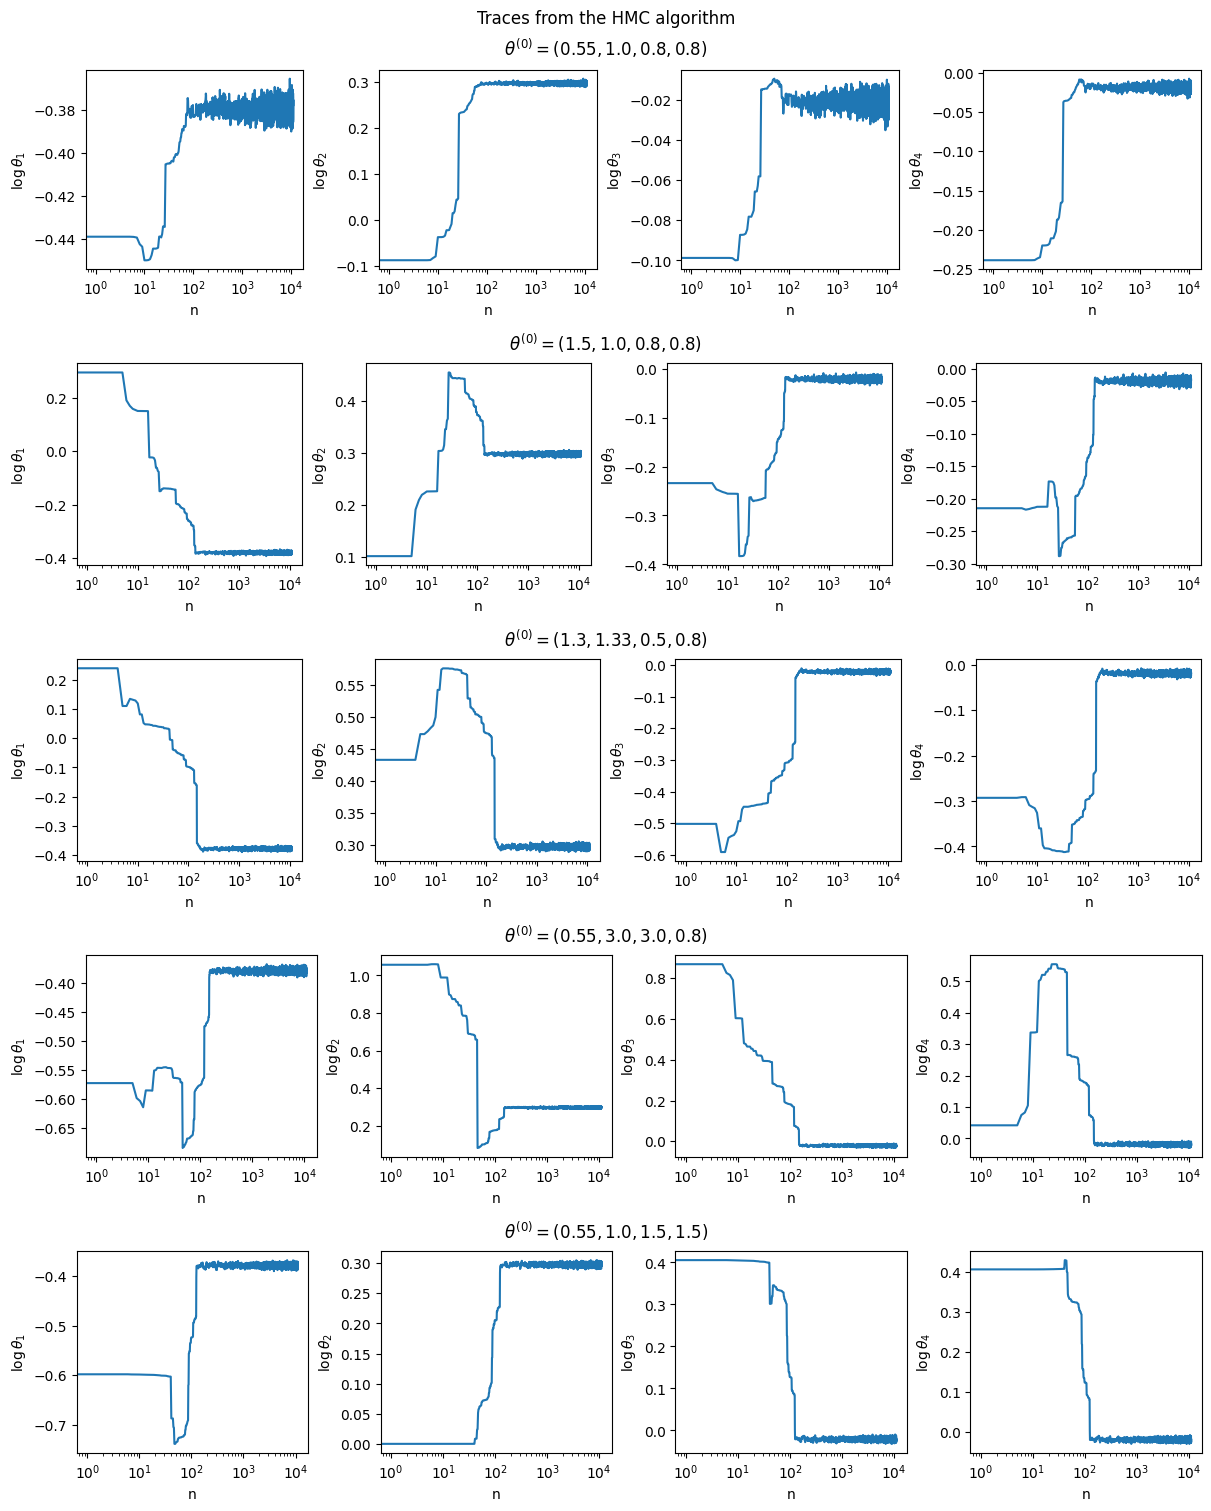

In [41]:
fig = plot_traces(hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the HMC algorithm');

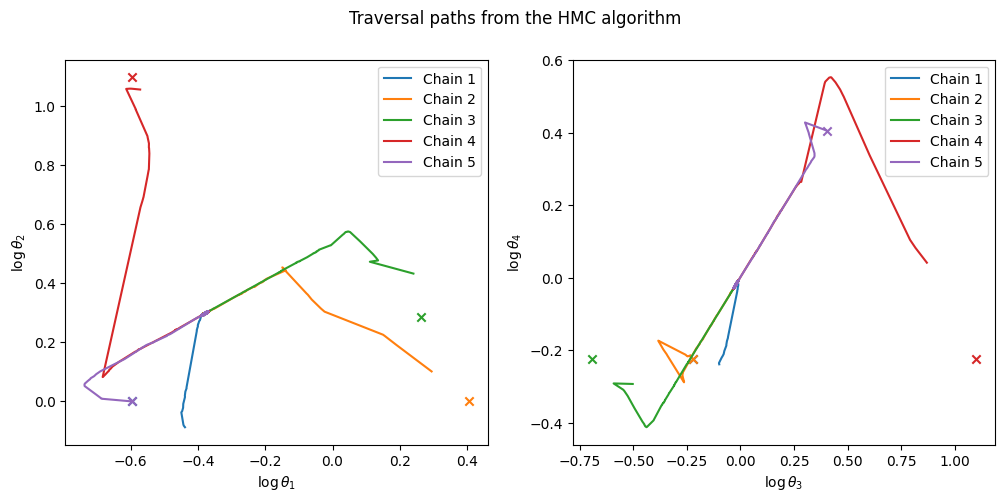

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths from the HMC algorithm');
plot_paths(hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');

In [43]:
[acceptance_rate(sample) for sample in hmc_samples]

[0.9928181818181818,
 0.9916363636363636,
 0.9904545454545455,
 0.9908181818181818,
 0.990909090909091]

Based on the thresholds in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_, the diagnostics do not suggest any convergence issues:

In [44]:
@cached(recalculate=recalculate, persist=True)
def hmc_az_summary() -> pd.DataFrame:
    return az.summary(to_arviz(hmc_samples, var_names=[f'log_theta{i + 1}' for i in range(d)]))

In [45]:
hmc_az_summary()

DEBUG:utils.caching:Reading from disk cache: hmc_az_summary
DEBUG:utils.caching:Reading ../data/generated/hmc_az_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta1,-0.379,0.028,-0.386,-0.373,0.002,0.001,2992.0,2735.0,1.0
log_theta2,0.298,0.025,0.293,0.302,0.001,0.001,4145.0,2989.0,1.0
log_theta3,-0.021,0.032,-0.027,-0.015,0.002,0.002,3115.0,2727.0,1.0
log_theta4,-0.019,0.030,-0.025,-0.013,0.002,0.001,3090.0,2697.0,1.0


### Validation HMC sample

We generate an additional sample that we will use to evaluate the quality of fit for the proposed methods.

In [46]:
validation_hmc_seed = 98765

In [47]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def validation_hmc_samples() -> list[np.ndarray]:
    inference_model = stan.build(
        stan_model_spec,
        data=data,
        random_seed=validation_hmc_seed,
    )
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=False,
        init=[{'log_theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'log_theta')

In [48]:
# force the calculation
validation_hmc_samples[0];

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_0.npy


DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading ../data/generated/validation_hmc_samples_4.npy


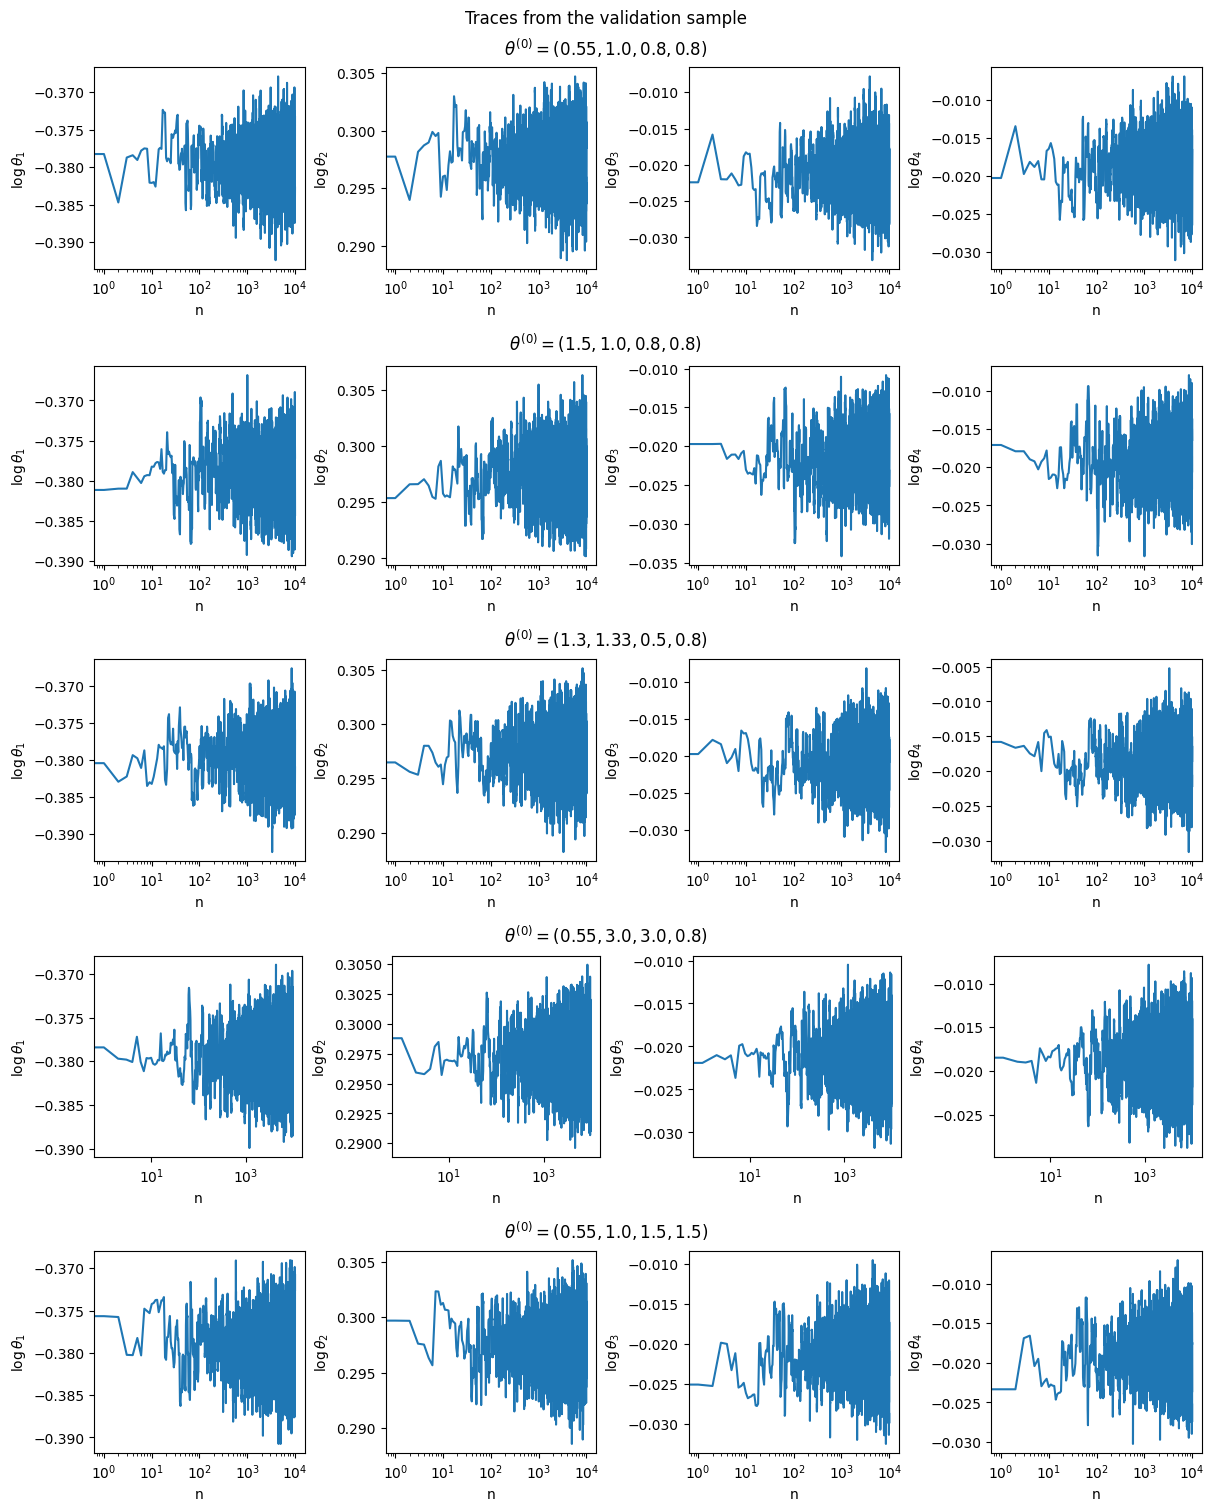

In [49]:
fig = plot_traces(validation_hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the validation sample');

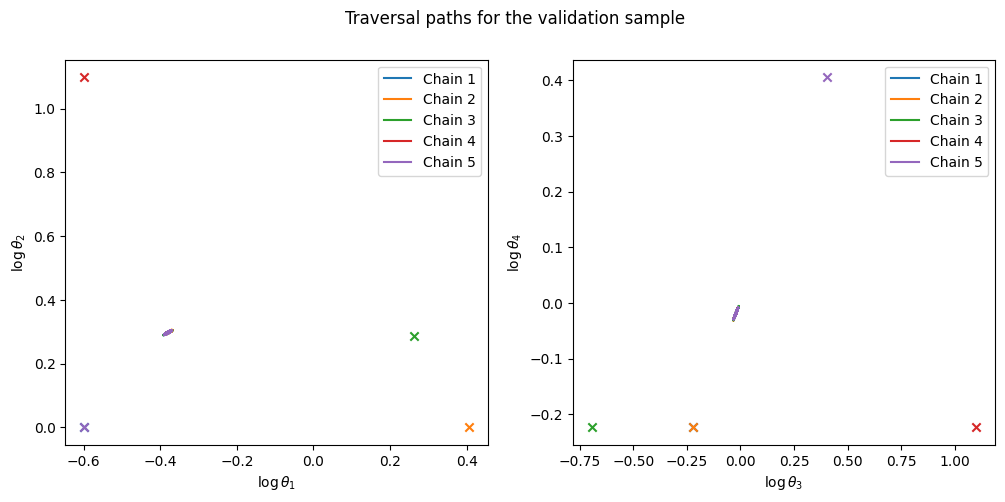

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths for the validation sample');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\log \\theta_1$', label2='$\\log \\theta_2$');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\log \\theta_3$', label2='$\\log \\theta_4$');

In [51]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

# Sensitivity analysis

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations (this is equation (35) in the Supplementary Material):
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [52]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [53]:
uw_init = np.concatenate([np.array(u_init), np.zeros(d * q)])

In [54]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 14.5 ms, sys: 1.32 ms, total: 15.8 ms
Wall time: 25.9 ms


Plot the solution again:

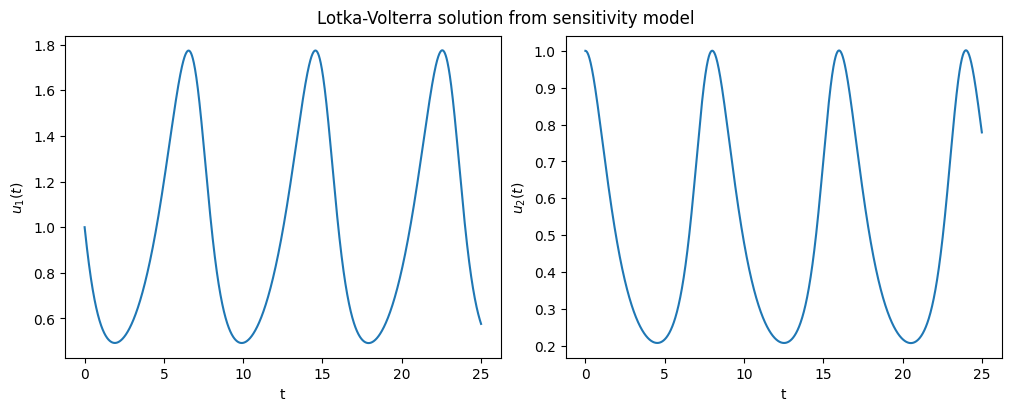

In [55]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model');
for i in range(q):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Plot the sensitivities:

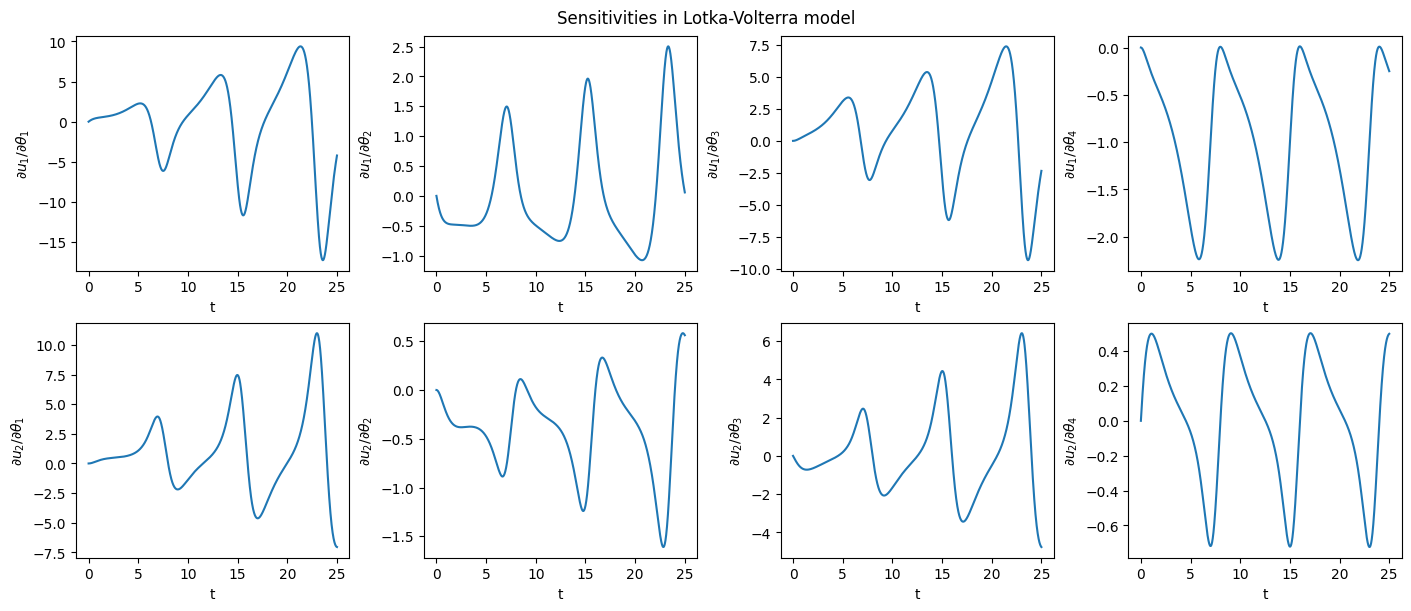

In [56]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Sensitivities in Lotka-Volterra model');
for i in range(q):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, q + i * d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

We need to redefine the function since ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [57]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [58]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))

In [59]:
sol2 = solve_lotka_volterra2(theta)

Plot the solution first:

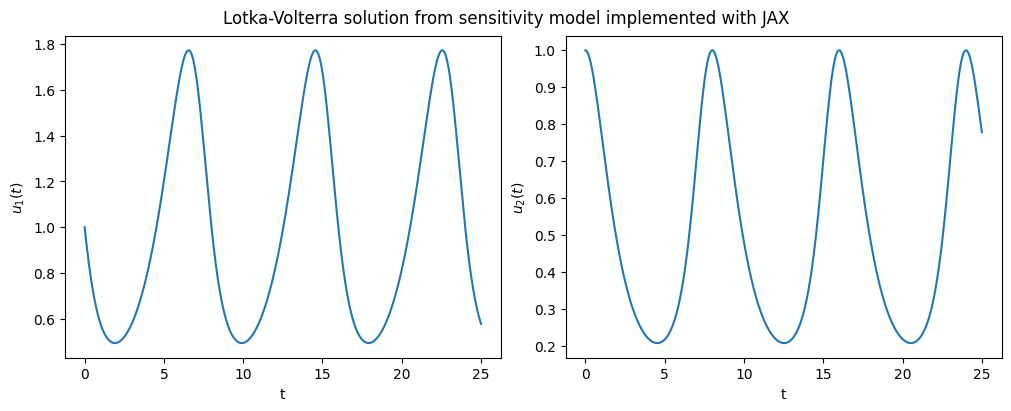

In [60]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model implemented with JAX');
for i in range(q):
    axs[i].plot(t, sol2[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Calculate the sensitivities:

In [61]:
@cached(recalculate=recalculate, persist=True)
def sensitivity_jax() -> np.ndarray:
    return np.stack(jacobian(solve_lotka_volterra2)(theta))

We confirm that the numerical method agrees with the results from forward sensitivity equations:

DEBUG:utils.caching:Reading from disk cache: sensitivity_jax
DEBUG:utils.caching:Reading ../data/generated/sensitivity_jax.npy


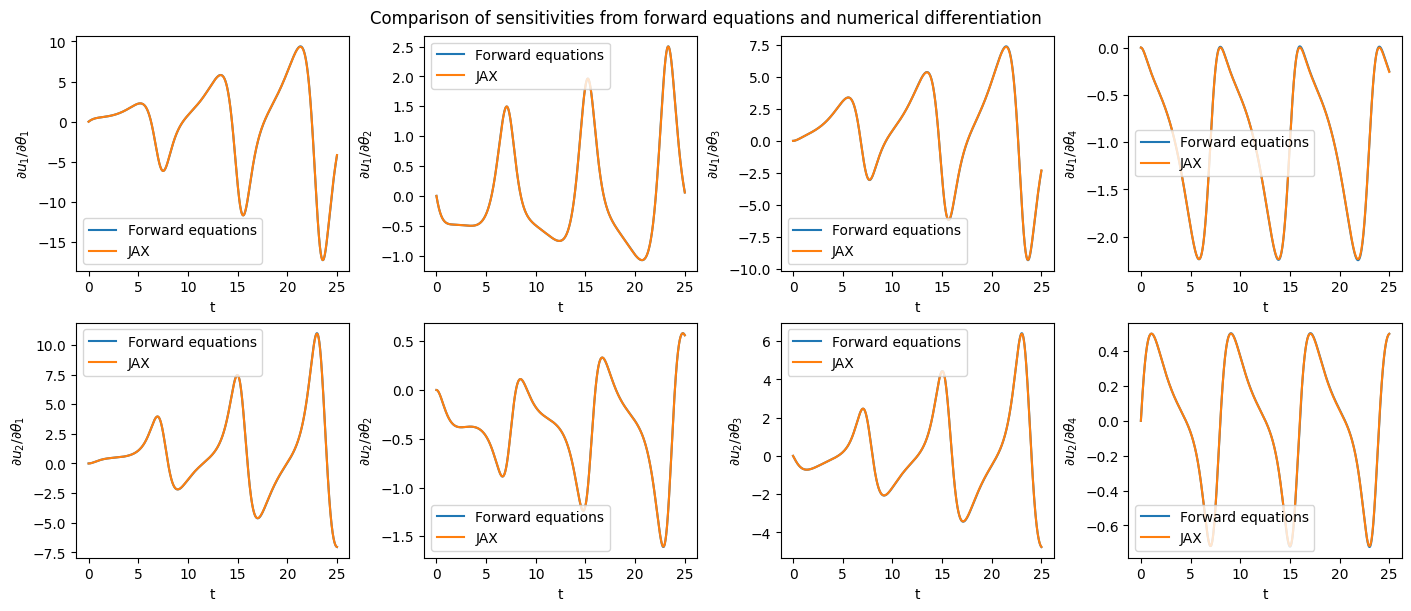

In [62]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Comparison of sensitivities from forward equations and numerical differentiation');
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j], label='Forward equations');
        axs[i][j].plot(t, sensitivity_jax()[j, :, i], label='JAX');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');
        axs[i][j].legend();

## Calculating the gradient of the log-posterior

The Stein Thinning methog requires the gradient of the log-posterior $\nabla \log p$ as input. Below we follow section S3 of the Supplementary Material to derive it.

Since $p(\pmb{\theta}) \propto \mathcal{L}(\pmb{\theta}) \pi(\pmb{\theta})$, we have 
$$\nabla_{\pmb{\theta}} \log p(\pmb{\theta}) = \nabla_{\pmb{\theta}} \log \mathcal{L}(\pmb{\theta}) + \nabla_{\pmb{\theta}} \log \pi(\pmb{\theta}).$$
Assuming independent errors in observations yields
$$\mathcal{L}(\pmb{\theta}) = \prod_{i=1}^N \phi_i(u(t_i)),$$
and thus 
$$
\frac{\partial}{\partial \theta_s} \log \mathcal{L}(\pmb{\theta}) 
= \sum_{i=1}^N \frac{\partial}{\partial \theta_s} \log \phi_i(u(t_i))
= \sum_{i=1}^N \sum_{r=1}^q \frac{\partial}{\partial u_r} (\log \phi_i) \frac{\partial u_r}{\partial \theta_s},
$$
which can be written in matrix notation as
$$(\nabla_{\pmb{\theta}} \log \mathcal{L})(\pmb{\theta}) = \sum_{i=1}^N \left(\frac{\partial \mathbf{u}}{\partial \pmb{\theta}}\right)^T\! (t_i)\, (\nabla_u \log \phi_i)(u(t_i)),$$
where
$$\left(\frac{\partial \mathbf{u}}{\partial \pmb{\theta}}\right)_{r,s} = \frac{\partial u_r}{\partial \theta_s}$$
is the matrix of sensitivities, as obtained earlier.

Note that this does not match the expression provided on page 16 of the Supplementary Material:
$$(\nabla \log \mathcal{L})(x) = -\sum_{i=1}^N \frac{\partial u}{\partial x}(t_i) (\nabla \log \phi_i)(u(t_i)),$$
where the Jacobian is not transposed and there is a minus sign in front of the expression.

For a multivariate normal distribution of the errors:
$$\phi_i(u(t_i)) \propto \exp\left( -\frac{1}{2} (y_i - u(t_i))^T C^{-1} (y_i - u(t_i)) \right)$$
we obtain
$$(\nabla_u \log \phi_i)(u(t_i)) = C^{-1}(y_i - u(t_i)).$$

We assume independent standard normal priors for all components $\xi_i = \log \theta_i$, therefore
$$\pi(\pmb{\theta}) = \prod_{i=1}^d \pi_i(\log \theta_i) \propto \exp\left(-\frac{1}{2}\sum_{i=1}^d (\log \theta_i)^2\right)$$
and
$$\nabla_{\pmb{\theta}} \log \pi(\pmb{\theta}) = -\frac{\log \pmb{\theta}}{\pmb{\theta}},$$
where both the logarithm and division are performed component-wise.

We calculate the gradient of the log-likelihood from the Jacobian obtained previosly:

In [63]:
# reshape the Jacobian so it can be multiplied by the gradient of log phi
J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
J.shape

(2400, 4, 2)

In [64]:
# calculate the gradient of log phi and reshape it
grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
grad_log_phi.shape

(2400, 2, 1)

In [65]:
grad_log_lik = np.sum(np.squeeze(J @ grad_log_phi), axis=0)
grad_log_lik

array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

Now put the calculation into a function so we can use it later:

In [66]:
def grad_log_likelihood(theta):
    """Solve the system of ODEs and calculate the log-likelihood"""
    sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
    sensitivity_forward = sol.sol(t).T
    J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
    grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
    return np.sum(np.squeeze(J @ grad_log_phi), axis=0)

In [67]:
%%time
grad_log_likelihood(theta)

CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 16.7 ms


array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

We check the numbers against the numerical gradient:

In [68]:
def grad_log_likelihood_jax(theta):
    import jax.scipy.stats as jstats
    def log_likelihood(theta):
        sol = odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))
        return jnp.sum(jstats.multivariate_normal.logpdf(jnp.array(y) - sol, mean=jnp.array(means), cov=jnp.array(C)))
    return jacobian(log_likelihood)(theta)

In [69]:
%%time
grad_log_likelihood_jax(theta)

CPU times: user 3.01 s, sys: 236 ms, total: 3.25 s
Wall time: 4.16 s


[Array(872.54626, dtype=float32, weak_type=True),
 Array(-144.05716, dtype=float32, weak_type=True),
 Array(307.38287, dtype=float32, weak_type=True),
 Array(64.167496, dtype=float32, weak_type=True)]

We use the gradient calculation based on solving forward sensitivity equations in what follows.

In [70]:
def grad_log_posterior(theta):
    return grad_log_likelihood(theta) - np.log(theta) / theta

In [71]:
grad_log_posterior(theta)

array([ 910.42608481, -161.56261572,  313.24871815,   71.0105305 ])

## Parallel calculation of gradients

We note that calculating gradients after a MCMC run is what is called "embarrassingly parallelisable" and the time required for this step can be effectively eliminated given sufficient computational resources. This is in contrast to the MCMC run itself, which is inherently sequential.

Here we demonstrate how the popular package ``Dask`` can be used to parallelise this computation across cores of a local machine.

See the notebook in ``examples/Dask_AWS.ipynb`` for a comparison between sequential calculation, parallel computation locally and on AWS.

We can save time by calculating the gradients for unique samples only:

A helper function to calculate gradients using unique values only:

In [72]:
def parallelise_for_unique(func, sample, row_chunk_size=200):
    """Calculate gradients for samples"""
    # we can save time by calculating gradients for unique samples only
    unique_samples, inverse_index = np.unique(sample, axis=0, return_inverse=True)
    res = apply_along_axis_parallel(func, 1, unique_samples, row_chunk_size, client)
    return res[inverse_index]

Calculate the gradients for the random-walk samples:

In [73]:
@subscriptable(n=len(theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(rw_samples[i]))

Calculate the gradients for HMC samples:

In [74]:
@subscriptable(n=len(theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_grads(i: int) -> np.ndarray:
    return parallelise_for_unique(grad_log_posterior, np.exp(hmc_samples[i]))

# Apply Stein thinning

### Random-walk sample

In [75]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

In [76]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_thinned_idx() -> list[np.ndarray]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    gradients = list(rw_grads)
    def calculate(i):
        return thin(np.exp(samples[i]), gradients[i], n_points_calculate, preconditioner='med')
    return map_parallel(calculate, range(len(theta_inits)))

Force recalculation when necessary:

In [77]:
%%time
#rw_thinned_idx.recalculate(persist=True);

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 10 μs


This reproduces the results shown in Figure S20 in the Supplementary Material:

DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_thinned_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_thinned_idx_4.npy


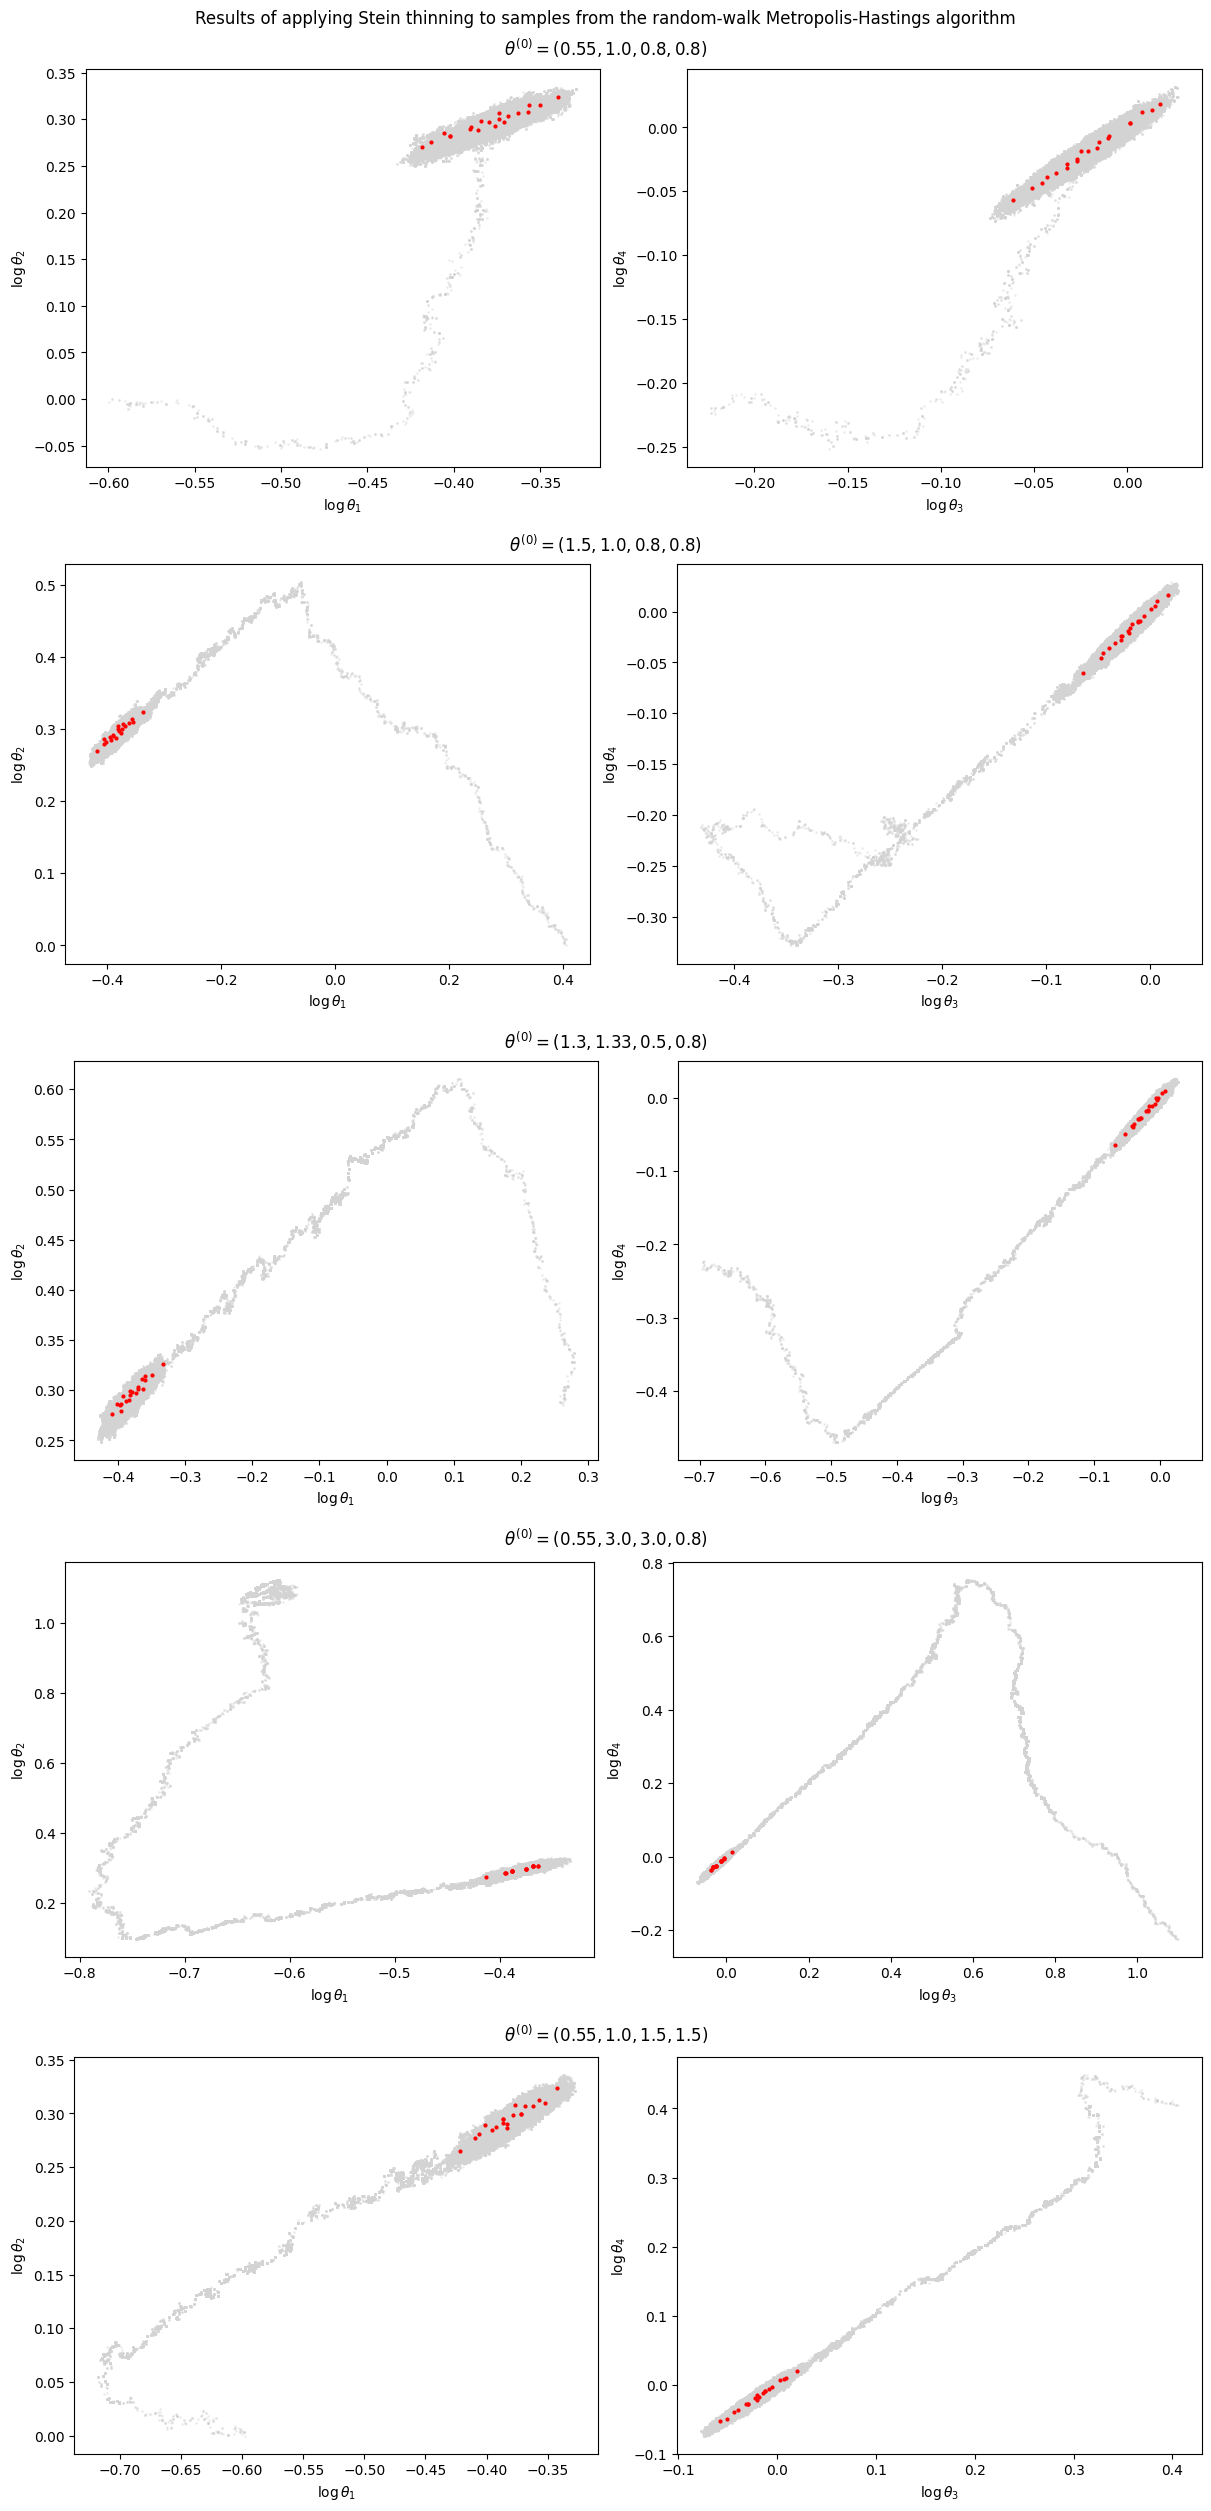

In [78]:
fig = plot_sample_thinned(rw_samples, rw_thinned_idx, titles, var_labels, n_points=n_points_display);
fig.savefig(figures_path / 'lotka-volterra-stein-thinning.png', dpi=300);
fig.suptitle('Results of applying Stein thinning to samples from the random-walk Metropolis-Hastings algorithm');

#### Log-transformation

Since inference is performed in log-space, it is natural to try Stein thinning in log-space as well.

If $\xi_i = \log \theta_i$, then by the chain rule we have
$$\frac{\partial f}{\partial \xi_i} = \sum_{j=1}^d \frac{\partial f}{\partial \theta_j} \frac{\partial \theta_j}{\partial \xi_i},$$
thus
$$\nabla_{\pmb{\xi}} \log p(\pmb{\xi}) = J^{-T} \nabla_{\pmb{\theta}} \log p(\pmb{\theta}),$$
where the Jacobian is $J = \text{diag}(\theta_1^{-1}, \dots, \theta_d^{-1})$, so $J^{-T} =  \text{diag}(\theta_1, \dots, \theta_d)$.

In [79]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_st_log_idx() -> list[np.ndarray]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    gradients = list(rw_grads)
    def calculate(i):
        return thin(samples[i], np.exp(samples[i]) * gradients[i], n_points_calculate, preconditioner='med')
    return map_parallel(calculate, range(len(theta_inits)))

Force recalculation when necessary:

In [80]:
%%time
#rw_st_log_idx.recalculate(persist=True);

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 8.82 μs


### HMC sample

In [81]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def hmc_thinned_idx(i: int) -> np.ndarray:
    return thin(np.exp(hmc_samples[i]), hmc_grads[i], n_points_thinned, preconditioner='med')

DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_0
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_1
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_2
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_3
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: hmc_thinned_idx_4
DEBUG:utils.caching:Reading ../data/generated/hmc_thinned_idx_4.npy


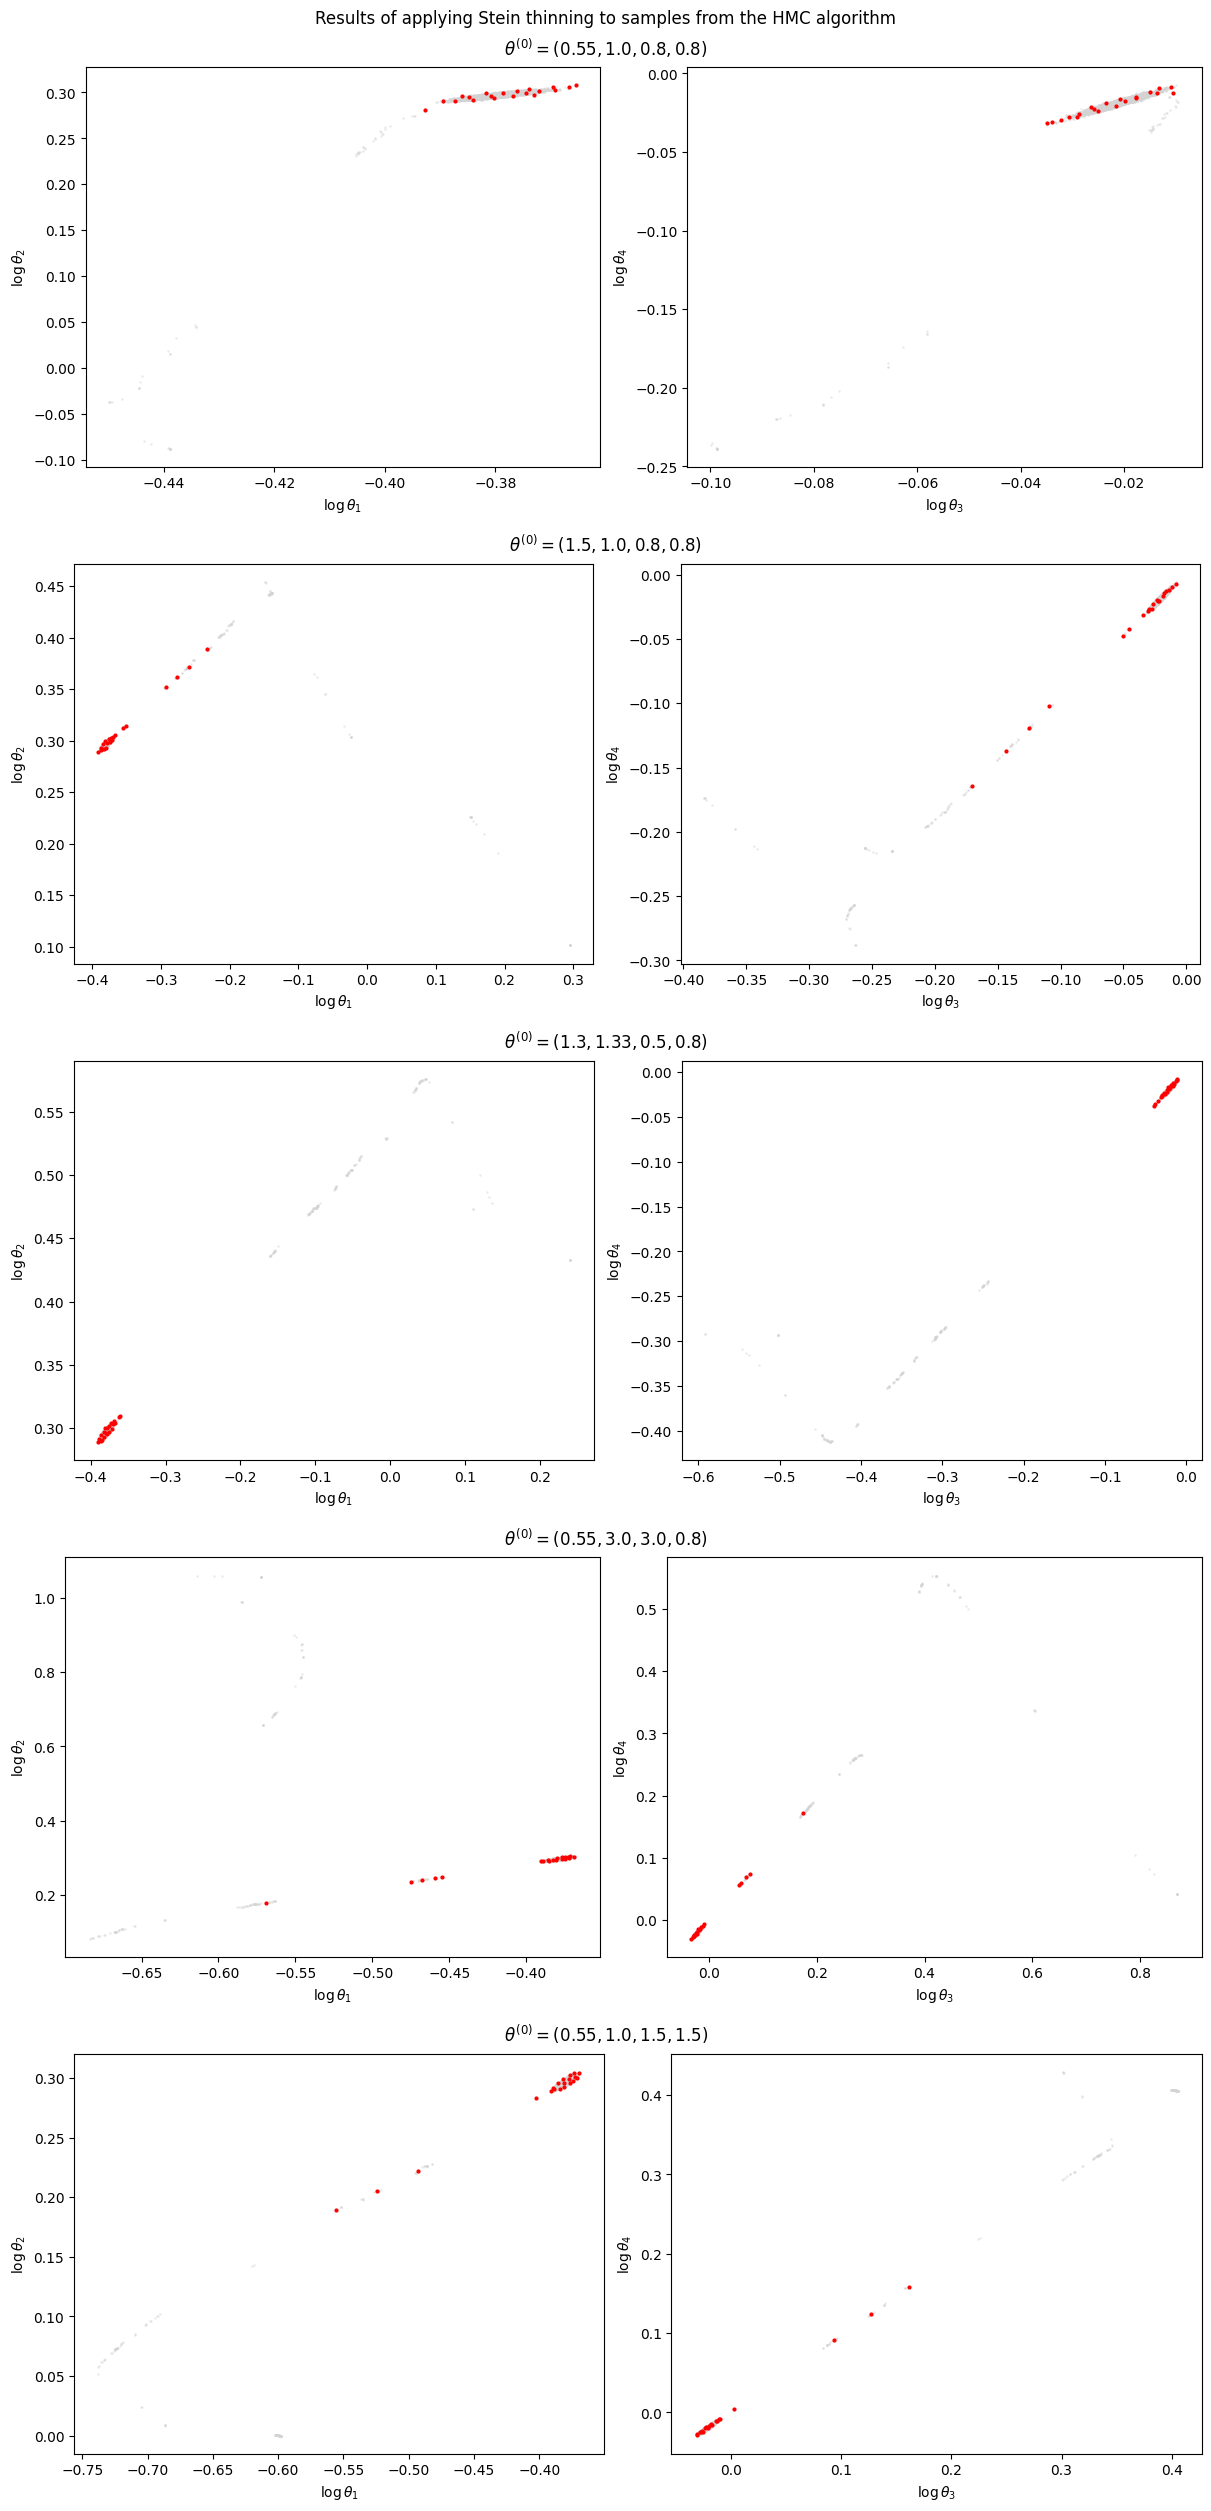

In [82]:
fig = plot_sample_thinned(hmc_samples, hmc_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the HMC algorithm');

# Naive thinning

The baseline for comparison is the naive thinning approach where we retain each $i$-th element of the sample.

In [83]:
def naive_thin(sample_size, thinned_size):
    return np.linspace(0, sample_size - 1, thinned_size).astype(int)

In [84]:
@subscriptable
@cached(recalculate=recalculate, persist=True)
def rw_naive_idx(i: int) -> np.ndarray:
    return naive_thin(rw_samples[i].shape[0], n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_0
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_1
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_2
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_3
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_naive_idx_4
DEBUG:utils.caching:Reading ../data/generated/rw_naive_idx_4.npy


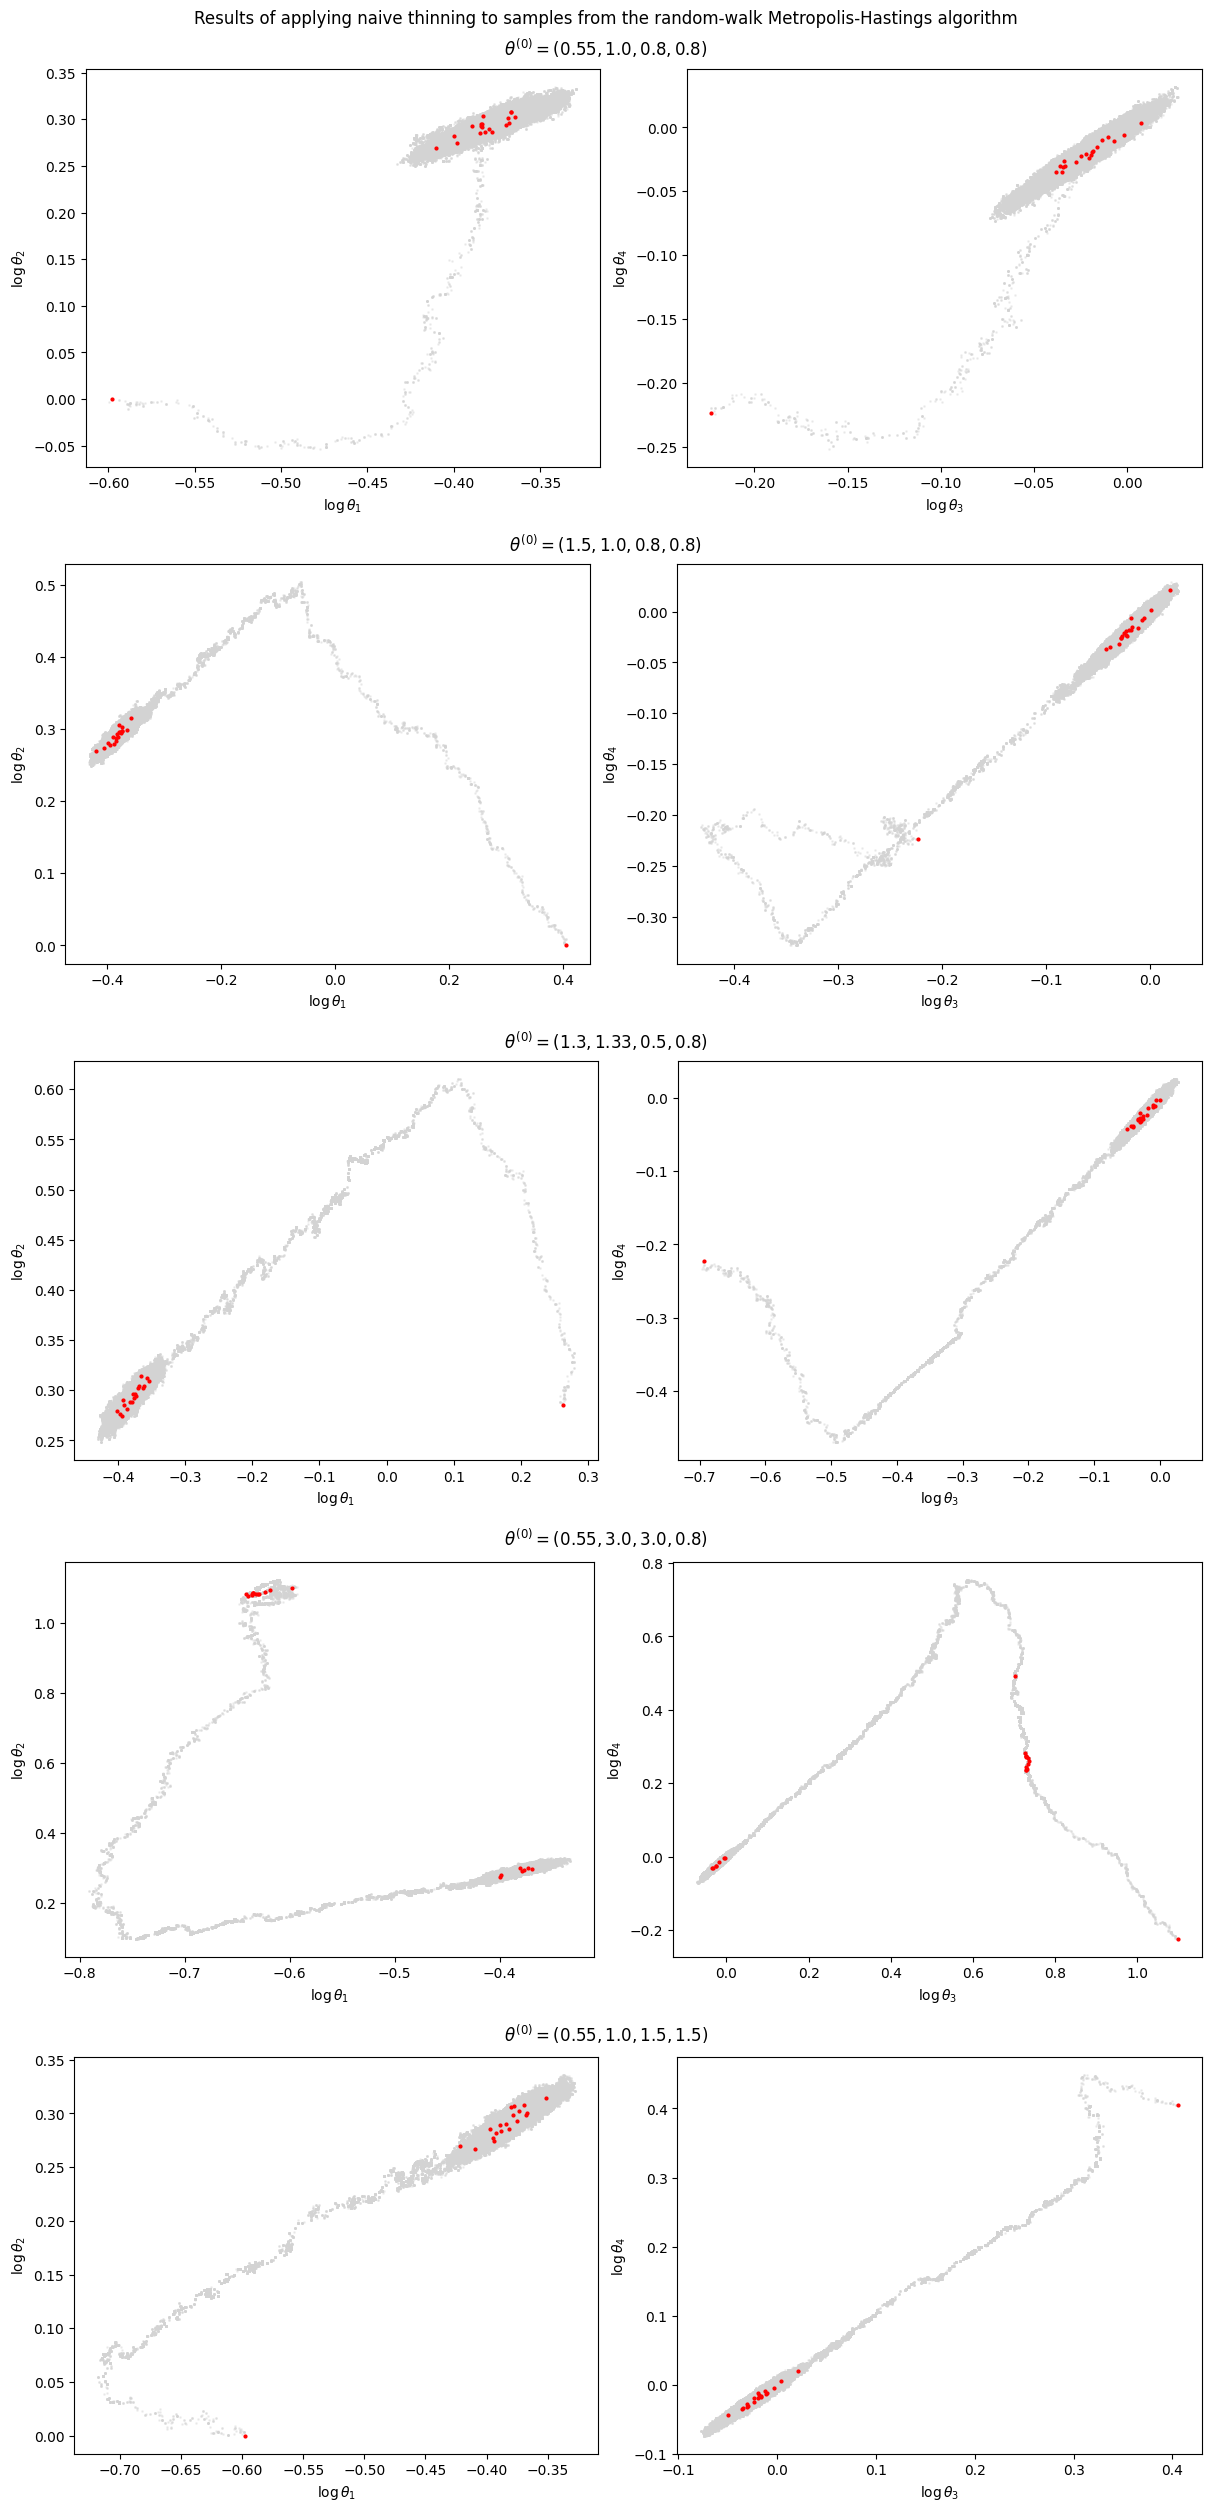

In [85]:
fig = plot_sample_thinned(rw_samples, rw_naive_idx, titles, var_labels);
fig.savefig(figures_path / 'lotka-volterra-naive-thinning.png', dpi=300);
fig.suptitle('Results of applying naive thinning to samples from the random-walk Metropolis-Hastings algorithm');

# Gradient-free Stein thinning

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [86]:
@subscriptable(n=len(theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [87]:
@subscriptable(n=len(theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Full sample

### Laplace proxy

In [88]:
def laplace_approximation(logpdf, x0):
    res = minimize(lambda x: -logpdf(x), x0, method='BFGS', options={'gtol': 1e-3})
    assert res.success
    return res.x, res.hess_inv

In [89]:
%%time
laplace_mean, laplace_cov = laplace_approximation(log_target_density, np.mean(rw_samples[0], axis=0))

CPU times: user 1.39 s, sys: 91.9 ms, total: 1.48 s
Wall time: 1.33 s


In [90]:
laplace_mean

array([-0.38253112,  0.29246496, -0.01989887, -0.01793044])

In [91]:
laplace_cov

array([[ 2.34793458e-05,  3.60158614e-05, -1.53824886e-05,
         3.46689365e-07],
       [ 3.60158614e-05,  6.56180950e-05, -2.12565683e-05,
        -2.70110977e-06],
       [-1.53824886e-05, -2.12565683e-05,  1.18664414e-05,
         4.49855438e-07],
       [ 3.46689365e-07, -2.70110977e-06,  4.49855439e-07,
         2.58154310e-06]])

In [92]:
def gaussian_thin(sample, log_p, mean, cov, thinned_size):
    log_q = mvn.logpdf(sample, mean=mean, cov=cov)
    gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(cov), sample - mean)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

The method clearly fails in this case:

In [93]:
gaussian_thin(rw_samples[0], rw_log_p[0], laplace_mean, laplace_cov, n_points_thinned)

DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading ../data/generated/rw_log_p_0.npy
/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using a proxy that matches the target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using a proxy that matches the target better')


array([231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231,
       231, 231, 231, 231, 231, 231, 231], dtype=uint32)

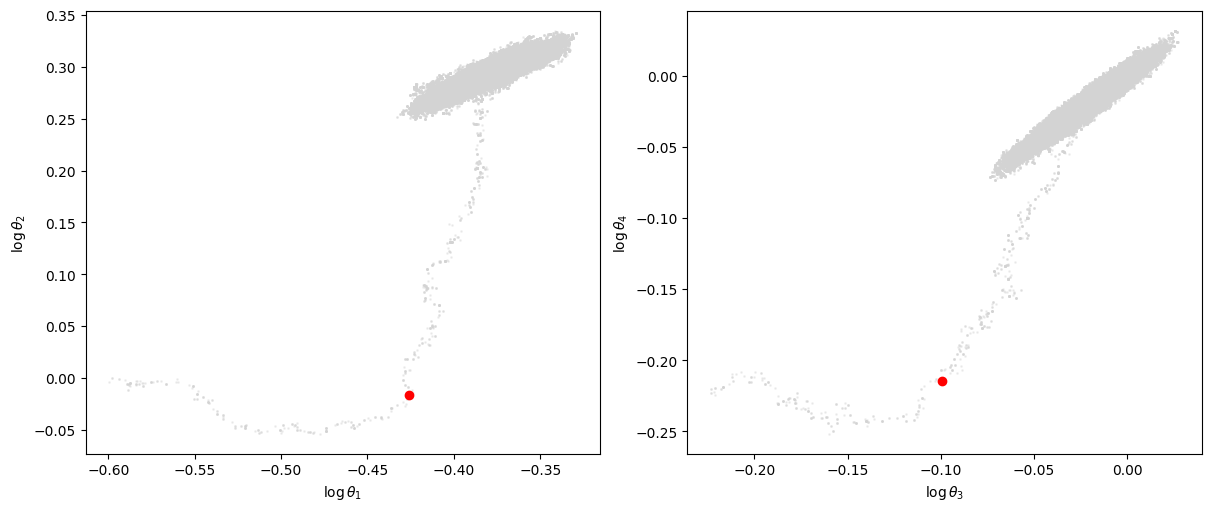

In [94]:
points_to_highlight = [231]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], points_to_highlight, [(0, 1), (2, 3)], axs, var_labels);

We calculate the proxy density at element 231:

In [95]:
log_q = mvn.logpdf(rw_samples[0], mean=laplace_mean, cov=laplace_cov)

In [96]:
log_q[231]

-26032762.34574922

In [97]:
rw_log_p[0][231]

-1290.111884958963

#### Numerical stability of optimisation

Using the default parameters in `scipy.optimize.minimize` results in a failure to find the optimum:

In [98]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -log_target_density(x), x0)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -852.0640163220094
        x: [-3.825e-01  2.925e-01 -1.990e-02 -1.793e-02]
      nit: 9
      jac: [ 8.316e-04 -5.646e-04 -7.629e-06  2.441e-04]
 hess_inv: [[ 7.863e-06  1.394e-05 -2.236e-06  2.310e-06]
            [ 1.394e-05  3.830e-05 -1.929e-06 -1.293e-06]
            [-2.236e-06 -1.929e-06  9.404e-07 -1.463e-06]
            [ 2.310e-06 -1.293e-06 -1.463e-06  2.815e-06]]
     nfev: 160
     njev: 32

Nelder-Mead succeeds:

In [99]:
x0 = np.mean(rw_samples[0], axis=0)
res = minimize(lambda x: -log_target_density(x), x0, method='Nelder-Mead')
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -852.0637592194984
             x: [-3.822e-01  2.926e-01 -2.023e-02 -1.826e-02]
           nit: 36
          nfev: 69
 final_simplex: (array([[-3.822e-01,  2.926e-01, -2.023e-02, -1.826e-02],
                       [-3.823e-01,  2.927e-01, -2.018e-02, -1.823e-02],
                       ...,
                       [-3.822e-01,  2.927e-01, -2.025e-02, -1.824e-02],
                       [-3.823e-01,  2.926e-01, -2.021e-02, -1.825e-02]]), array([-8.521e+02, -8.521e+02, -8.521e+02, -8.521e+02,
                       -8.521e+02]))

However, the Hessian evaluated at the maximum does not appear to be negative definite:

In [100]:
from numdifftools import Hessian

In [101]:
%%time
hess = Hessian(log_target_density)(res.x)
hess

CPU times: user 4.76 s, sys: 435 ms, total: 5.19 s
Wall time: 4.7 s


array([[-1196095.2214617 ,   329406.57616248, -1108270.83676384,
          106697.01289121],
       [  329406.57616248,  -118085.88891696,   257880.48682208,
           -6315.21068702],
       [-1108270.83676384,   257880.48682208, -1147544.69390286,
          228865.43619375],
       [  106697.01289121,    -6315.21068702,   228865.43619375,
          -97166.87432036]])

In [102]:
np.linalg.eigvals(hess)

array([-2381433.96995493,  -181583.12354665,    22522.02454574,
         -18397.60964605])

In [103]:
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [104]:
is_positive_definite(-hess)

False

### Gaussian proxy

In [105]:
sample_mean = np.mean(rw_samples[0], axis=0)
sample_cov = np.cov(rw_samples[0], rowvar=False, ddof=4)

In [106]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [107]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [108]:
idx = gaussian_thin(rw_samples[0], rw_log_p[0], sample_mean, sample_cov, n_points_thinned)
idx

/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using a proxy that matches the target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using a proxy that matches the target better')


array([427710, 149313, 490046, 428495, 183198,  80507, 268793, 367968,
       492726, 361480, 427710,  58196, 136691,  69676, 247516, 309270,
       427714,   3817,  15125, 293372], dtype=uint32)

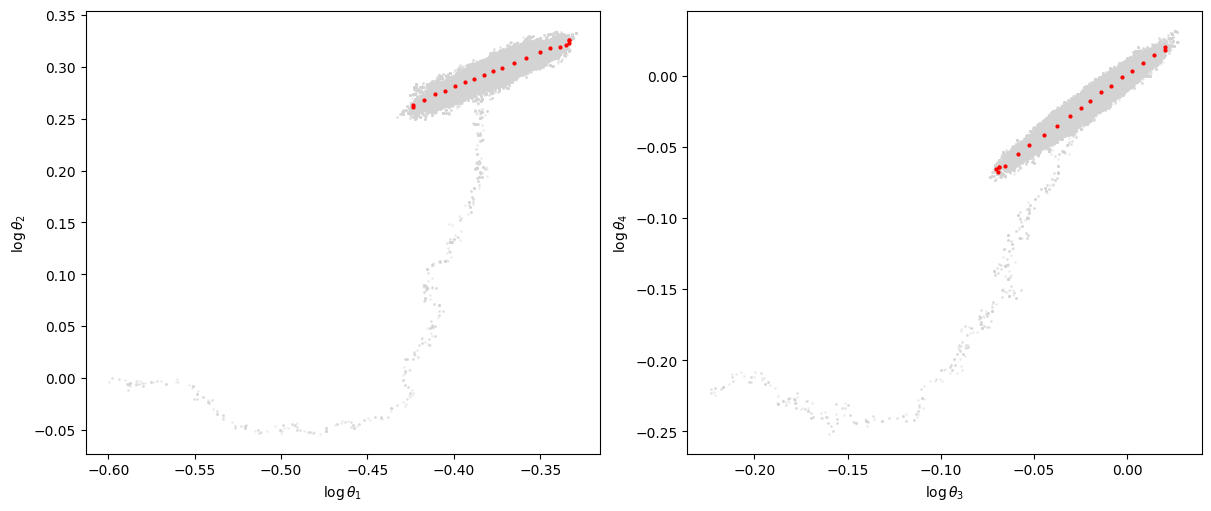

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

### Student t proxy

In [110]:
from scipy.optimize import OptimizeResult
from scipy.special import gamma

In [111]:
def extract_t_params(par, d):
    # upper-triangular elements of an n-by-n matrix
    n_cov = d * (d + 1) // 2

    # the means of the multivariate t are in the first `d` elements
    mu = par[:d]
    # the upper triangular elements of A are in the following `n_cov` elements
    A = np.zeros((d, d))
    A[np.triu_indices(d)] = par[d:d + n_cov]
    # the scale matrix
    scale = A.T @ A
    # the degrees of freedom value is the last element of `par`
    df = par[d + n_cov]

    return mu, scale, df

def fit_mvt(
        Y: np.ndarray,
        mu_bounds: tuple[float, float],
        a_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu_init: np.ndarray = None,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables
    n_cov = d * (d + 1) // 2  # upper-triangular elements of an n-by-n matrix

    # the starting values for the search
    if mu_init is None:
        mu_init = np.mean(Y, axis=0)
    sample_cov = np.cov(Y, rowvar=False, ddof=d)
    A = np.linalg.cholesky(sample_cov).T
    start = np.concatenate([mu_init, A[np.triu_indices(d)], [df_init]])

    # the bounds for the search
    lower = np.array([mu_bounds[0]] * d + [a_bounds[0]] * n_cov + [df_bounds[0]])
    upper = np.array([mu_bounds[1]] * d + [a_bounds[1]] * n_cov + [df_bounds[1]])

    def loglik_mvt(Y: np.ndarray, par: np.ndarray) -> float:
        mu, scale, df = extract_t_params(par, Y.shape[1])
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=scale, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta)

    bounds = list(zip(lower, upper))

    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

def fit_mvt2(
        Y: np.ndarray,
        scale_bounds: tuple[float, float],
        df_bounds: tuple[float, float],
        mu: np.ndarray,
        scale_init: float = 0.0,
        df_init: float = 4.,
        method: str = 'L-BFGS-B',
        options: dict = None,
) -> OptimizeResult:
    """Fit a multivariate t-distribution using maximum likelihood

    Parameters
    ----------
    Y: np.ndarray
        the input data: rows are observations, columns are variables
    mu_bounds: Tuple[float, float]
        the lower and upper bounds for means
    a_bounds: Tuple[float, float]
        the lower and upper bounds for values in the matrix A, where A.T @ A ~ Cov(Y)
    df_bounds: Tuple[float, float]
        the lower and upper bounds for the degree of freedom parameter

    Returns
    -------
    OptimizeResult
        the result of fitting a multivariate t-distribution
    """
    d = Y.shape[1]  # the number of variables

    # the starting values for the search
    sample_cov = np.cov(Y, rowvar=False, ddof=d)

    def loglik_mvt(Y: np.ndarray, scale, df) -> float:
        return -np.sum(stats.multivariate_t.logpdf(Y, loc=mu, shape=np.exp(scale) * sample_cov, df=df))

    def objective_func(beta):
        return loglik_mvt(Y, beta[0], beta[1])

    bounds = [scale_bounds, df_bounds]

    start = np.array([scale_init, df_init])
    return minimize(objective_func, start, method=method, bounds=bounds, options=options)

In [112]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=OptimizeResult, recalculate=recalculate, persist=True)
def rw_t_fit() -> list[OptimizeResult]:
    # we have to instantiate the array here as the caching function currently cannot be serialised
    samples = list(rw_samples)
    def calculate(i):
        return fit_mvt(samples[i], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 15), df_init=3.)
    return map_parallel(calculate, range(len(theta_inits)))

Force recalculation when necessary:

In [113]:
#rw_t_fit.recalculate(persist=True);

In [114]:
%%time
fit = fit_mvt(rw_samples[0], mu_bounds=(-0.5, 0.5), a_bounds=(-0.1, 0.1), df_bounds=(2, 30), df_init=4.)
fit

CPU times: user 4min 48s, sys: 4min 59s, total: 9min 47s
Wall time: 2min 41s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -8155729.119366754
        x: [-3.826e-01  2.920e-01 ...  2.804e-03  1.289e+01]
      nit: 263
      jac: [ 7.629e+02  6.154e+03 ... -4.505e+03 -1.956e+00]
     nfev: 4544
     njev: 284
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [115]:
t_mu, t_scale, t_df = extract_t_params(fit.x, d)

In [116]:
sample_mode = rw_samples[0][np.argmax(rw_log_p[0])]
fit2 = fit_mvt2(rw_samples[0], scale_bounds=(-20, 20), df_bounds=(2, 30), mu=sample_mode)
fit2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -7701532.9296034295
        x: [-6.643e-01  9.456e+00]
      nit: 12
      jac: [-1.304e+00 -9.313e-02]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [117]:
t_mu = sample_mode
t_scale = np.cov(rw_samples[0], rowvar=False, ddof=d) * np.exp(fit2.x[0])
t_df = fit2.x[1]

In [118]:
t_mu

array([-0.38262152,  0.2922964 , -0.01989471, -0.01783209])

In [119]:
t_scale

array([[ 1.09611833e-04,  8.38837489e-05, -9.86237875e-05,
        -8.86945656e-05],
       [ 8.38837489e-05,  1.01512724e-04, -5.26867153e-05,
        -3.28133639e-05],
       [-9.86237875e-05, -5.26867153e-05,  1.11649693e-04,
         1.09799881e-04],
       [-8.86945656e-05, -3.28133639e-05,  1.09799881e-04,
         1.18833740e-04]])

In [120]:
t_df

9.456167660133405

In [121]:
t_df = np.round(t_df)
t_df

9.0

The density of the multivaritate Student's t distribution is given by
$$f(\mathbf{x}) = \frac{\Gamma\left(\frac{\nu + d}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \nu^{\frac{d}{2}} \pi^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} \left[1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})\right]^{-\frac{\nu + d}{2}}.$$
The gradient of the log-density is then
$$\nabla_{\mathbf{x}} \log f(\mathbf{x}) = -\frac{\nu + d}{\nu} \frac{\Sigma^{-1} (\mathbf{x} - \pmb{\mu})}{1 + \frac{1}{\nu} (\mathbf{x} - \pmb{\mu})^T \Sigma^{-1} (\mathbf{x} - \pmb{\mu})}$$

We implement the log-density of the multivariate t and confirm that it matches what is returned by `scipy`:

In [122]:
def t_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    return (
        np.log(gamma((df + d) / 2))
        - np.log(gamma(df  / 2))
        - d * (np.log(df) + np.log(np.pi)) / 2
        - np.log(np.linalg.det(sigma)) / 2
        -(df + d) / 2 * np.log(1 + np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu) / df)
    )

In [123]:
log_q = stats.multivariate_t.logpdf(rw_samples[0], loc=t_mu, shape=t_scale, df=t_df)

In [124]:
np.testing.assert_allclose(t_log_pdf(rw_samples[0], t_mu, t_scale, t_df), log_q)

In [125]:
def t_grad_log_pdf(x, mu, sigma, df):
    d = x.shape[1]
    sigma_inv = np.linalg.inv(sigma)
    x_mu = x - mu
    direction_scaled = np.einsum('jk,ik->ij', sigma_inv, x_mu)
    mahalanobis_d = np.einsum('ij,jk,ik->i', x_mu, sigma_inv, x_mu)
    return -(df + d) / df / (1 + mahalanobis_d / df).reshape(-1, 1) * direction_scaled

In [126]:
def thin_gf_t(sample, log_p, t_mu, t_scale, t_df, thinned_size):
    log_q = stats.multivariate_t.logpdf(sample, loc=t_mu, shape=t_scale, df=t_df)
    gradient_q = t_grad_log_pdf(sample, t_mu, t_scale, t_df)
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size, range_cap=200)

In [127]:
idx = thin_gf_t(rw_samples[0], rw_log_p[0], t_mu, np.cov(rw_samples[0], rowvar=False, ddof=d) * 3, 4, 100)
idx

array([210376, 442969,  80507,  51956, 392030,  55794, 249886, 428495,
       284066, 397477,  58914, 113015,  19535, 341822, 349159, 430931,
       245786, 222623, 279220, 465968, 437304, 499762,  97484, 285752,
       318398, 366902, 392297, 173240, 192217, 246329,  32814, 430204,
       456038, 131209, 396729, 297862, 372321, 289076, 378348, 283826,
       215531, 274665, 236412, 411800, 493992, 164977, 449619, 464124,
       271127, 301248,  69014, 264791,  58495, 478448, 471186, 490046,
       396803, 359110, 468104, 439100, 160255, 317689, 142635, 413010,
       238704, 218919, 411041, 106757, 387864, 476932, 149313, 247965,
       387974, 433207, 139123, 474510, 259443, 418138, 430931,  92115,
        98812, 320672,  31205,  22933,  39812, 337220,  34004, 129779,
       269834, 460980, 465955, 115317, 325680, 389154, 311114, 141151,
       439171,  43873, 199242, 147363], dtype=uint32)

In [128]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [129]:
fit_quality(rw_samples[0][rw_thinned_idx[0][:100]])

0.10837416731318722

In [130]:
fit_quality(rw_samples[0][idx[:100]])

0.09488942311259109

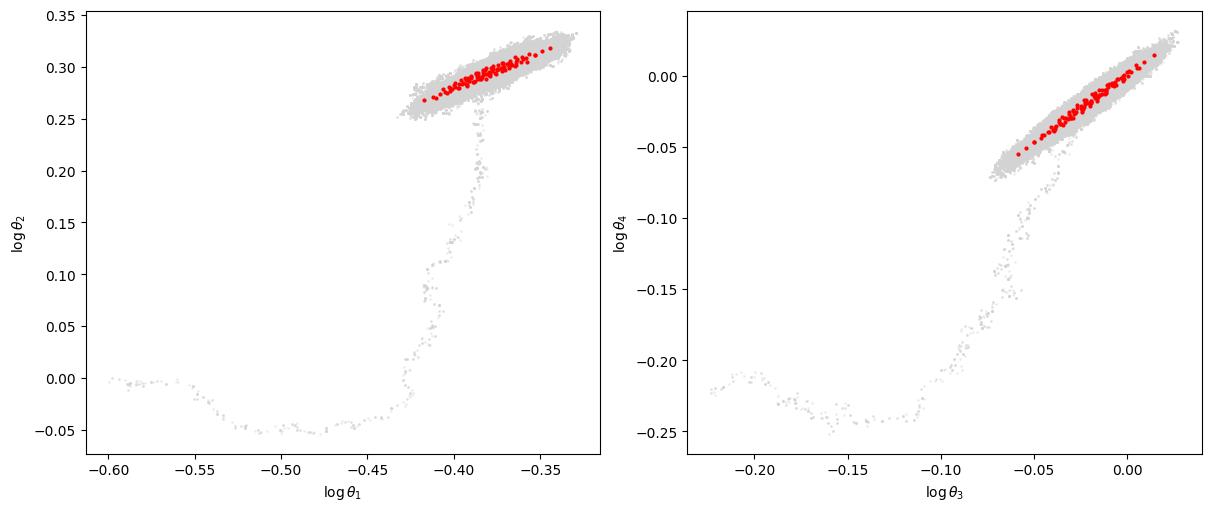

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(rw_samples[0], idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

In [132]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    t_fits = list(rw_t_fit)
    def calculate(i):
        t_mu, t_scale, t_df = extract_t_params(t_fits[i].x, d)
        return thin_gf_t(samples[i], log_ps[i], t_mu, t_scale, t_df, n_points_calculate)
    return map_parallel(calculate, range(len(theta_inits)))

In [133]:
#rw_gf_t_idx.recalculate(persist=True);

In [134]:
@subscriptable(n=len(theta_inits))
@cached_batch(item_type=np.ndarray, recalculate=recalculate, persist=True)
def rw_gf_t2_idx() -> list[np.ndarray]:
    samples = list(rw_samples)
    log_ps = list(rw_log_p)
    def calculate(i):
        sample_mode = samples[i][np.argmax(log_ps[i])]
        sample_cov = np.cov(samples[i], rowvar=False, ddof=4)
        return thin_gf_t(samples[i], log_ps[i], sample_mode, sample_cov * 3, 4, n_points_calculate)
    return map_parallel(calculate, range(len(theta_inits)))

In [135]:
#rw_gf_t2_idx.recalculate(persist=True);

## Sample with burn-in removed manually

We plot the difference in log-probability versus the squared Euclidean distance from the sample mode:

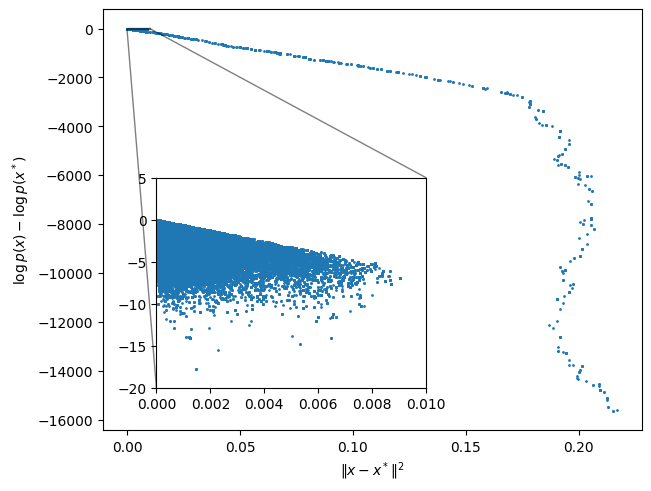

In [136]:
i = 0
sample = rw_samples[i]
sample_mean = np.mean(sample, axis=0)
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample[ref_idx].reshape(1, -1), sample).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(dists ** 2, prob_diff, s=1);
ax.set_xlabel('$\\|x - x^* \\|^2$');
ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');

inset_xlim = [0, 0.01]
inset_ylim = [-20, 5]

ax_ins = ax.inset_axes([0.1, 0.1, 0.5, 0.5], xlim=inset_xlim, ylim=inset_ylim)
ax.indicate_inset_zoom(ax_ins, edgecolor="black")

ax_ins.scatter(dists ** 2, prob_diff, s=1);
ax_ins.set_xlim(inset_xlim);
ax_ins.set_ylim(inset_ylim);

We can us the threshold of -15 to locate the bulk of the sample.

In [137]:
cond = prob_diff > -15 

This retains most of the points:

In [138]:
np.sum(cond) / rw_samples[0].shape[0]

0.9985880028239944

The resulting subsample:

In [139]:
subsample = rw_samples[0][cond]
subsample_log_p = rw_log_p[0][cond]

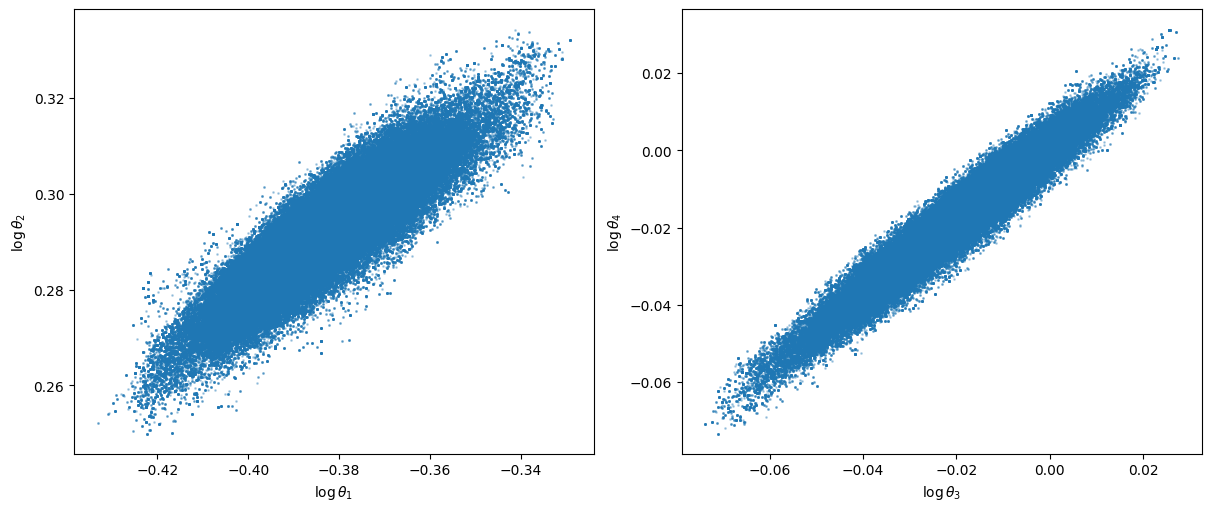

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None);

### Laplace proxy

The parameters of the Laplace proxy do not change, since they are estimated from the posterior distribution rather than the sample.

Thinning fails in this case again:

In [141]:
gaussian_thin(subsample, subsample_log_p, laplace_mean, laplace_cov, n_points_thinned)

array([426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876], dtype=uint32)

In [142]:
subsample_log_p[426876]

844.9508392811421

In [143]:
subsample_log_q = mvn.logpdf(subsample, mean=laplace_mean, cov=laplace_cov)

In [144]:
subsample_log_q[426876]

-2222650.067328276

Again, the tail of the proxy distribution is too thin relative to the target.

### Gaussian proxy

In [145]:
subsample_mean = np.mean(subsample, axis=0)
subsample_cov = np.cov(subsample, rowvar=False, ddof=4)

In [146]:
subsample_mean

array([-0.3825417 ,  0.29205248, -0.02000333, -0.01804386])

In [147]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

The values calculated from the subsample are very close to those obtained from the full sample:

In [148]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [149]:
sample_cov

array([[ 2.12987627e-04,  1.62995182e-04, -1.91636668e-04,
        -1.72343118e-04],
       [ 1.62995182e-04,  1.97250184e-04, -1.02375977e-04,
        -6.37599091e-05],
       [-1.91636668e-04, -1.02375977e-04,  2.16947410e-04,
         2.13353024e-04],
       [-1.72343118e-04, -6.37599091e-05,  2.13353024e-04,
         2.30906788e-04]])

In [150]:
idx = gaussian_thin(subsample, subsample_log_p, subsample_mean, subsample_cov, n_points_thinned)
idx

array([308570, 180846, 308583, 148608, 488658, 199095, 288880, 308442,
       367029, 435695, 192615, 268581, 308647, 180846, 431046, 319012,
        71864, 404187, 135986, 493971], dtype=uint32)

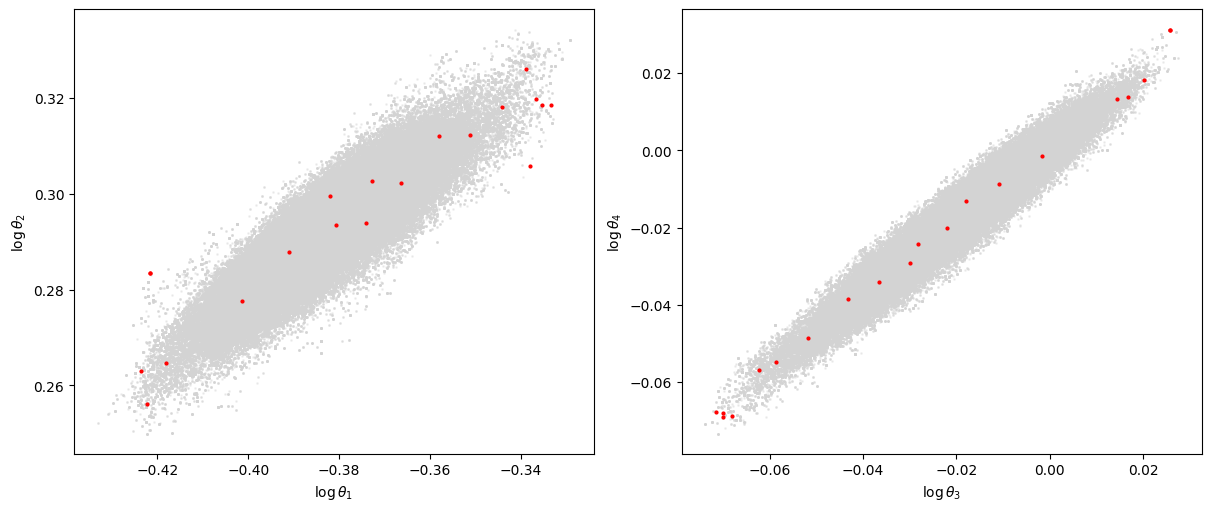

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

# Energy distance comparison

In [152]:
def fit_quality(subsample, validation_sample_step=10):
    return np.sqrt(dcor.energy_distance(validation_sample[::validation_sample_step], subsample))

In [153]:
def naive_idx(n, m):
    return np.linspace(0, n - 1, m).astype(int)

In [154]:
thinned_size_series = []
thinned_size_series.append(np.linspace(5, 100, 50).astype(int))
thinned_size_series.append(np.linspace(100, n_points_calculate, 200).astype(int))
thinned_sizes = np.concatenate(thinned_size_series)

In [155]:
@cached(recalculate=recalculate, persist=True)
def rw_energy_distance(i_chain, idx_name) -> np.ndarray:
    sample = rw_samples[i_chain]
    idx = globals()[idx_name][i_chain]
    energy_distances = np.fromiter((fit_quality(sample[idx[:thinned_size]]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [156]:
@cached(recalculate=recalculate, persist=True)
def rw_energy_distance_naive(i_chain) -> np.ndarray:
    sample = rw_samples[i_chain]
    n = sample.shape[0]
    energy_distances = np.fromiter((fit_quality(sample[naive_idx(n, thinned_size)]) for thinned_size in thinned_sizes), float)
    return np.stack([thinned_sizes, energy_distances], axis=1)

In [157]:
indices_to_plot = {
    'rw_thinned_idx': 'Stein',
    'rw_st_log_idx': 'Stein log',
    'rw_naive': 'Naive',
}

In [158]:
def get_indices(name):
    if name == 'rw_naive':
        return rw_energy_distance_naive
    else:
        return lambda i: rw_energy_distance(i, name)

DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_thinned_idx
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_0_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_0_rw_st_log_idx
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_0_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_naive_0
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_naive_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_thinned_idx
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_1_rw_thinned_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_1_rw_st_log_idx
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_1_rw_st_log_idx.npy
DEBUG:utils.caching:Reading from disk cache: rw_energy_distance_naive_1
DEBUG:utils.caching:Reading ../data/generated/rw_energy_distance_naive_1.npy
DEBUG:utils.caching:Reading from disk 

CPU times: user 2.49 s, sys: 457 ms, total: 2.94 s
Wall time: 2.88 s


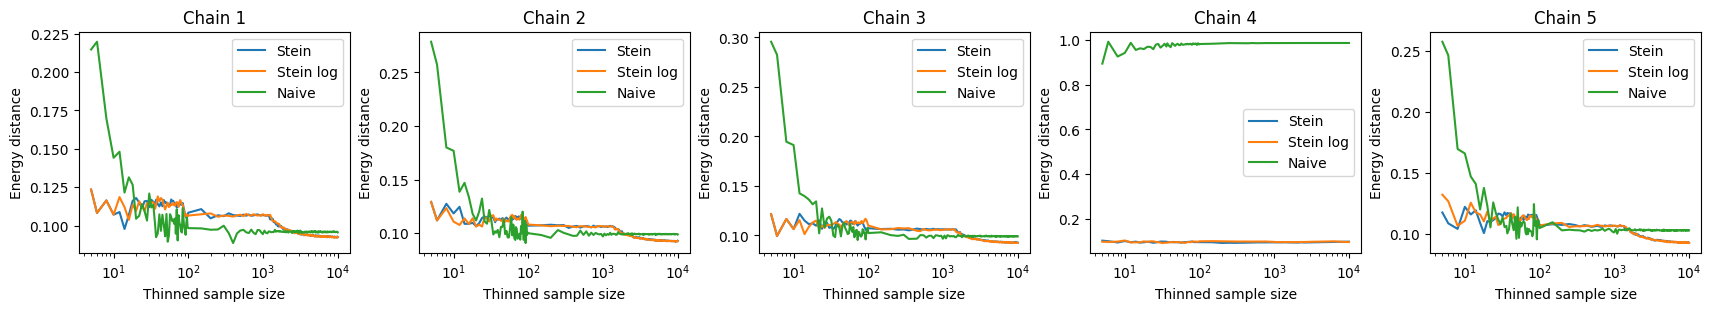

In [159]:
%%time
fig, axs = plt.subplots(1, len(theta_inits), figsize=(17, 3), constrained_layout=True)
for j in range(len(theta_inits)):
    for idx_name, label in indices_to_plot.items():
        res = get_indices(idx_name)(j)
        axs[j].plot(res[:, 0], res[:, 1], label=label);
    axs[j].set_xlabel('Thinned sample size');
    axs[j].set_ylabel('Energy distance');
    axs[j].set_title(f'Chain {j + 1}');
    axs[j].legend();
    axs[j].set_xscale('log');
fig.savefig(figures_path / 'lotka-volterra-stein-thinning-energy-distance.pdf');

In [168]:
indices_to_plot = {
    'rw_naive': 'Naive',
    'rw_thinned_idx': 'Stein',
    'rw_gf_t_idx': 'Gradient-free: t optimised',
    'rw_gf_t2_idx': 'Gradient-free: t fixed',
}

CPU times: user 2.11 s, sys: 550 ms, total: 2.66 s
Wall time: 2.07 s


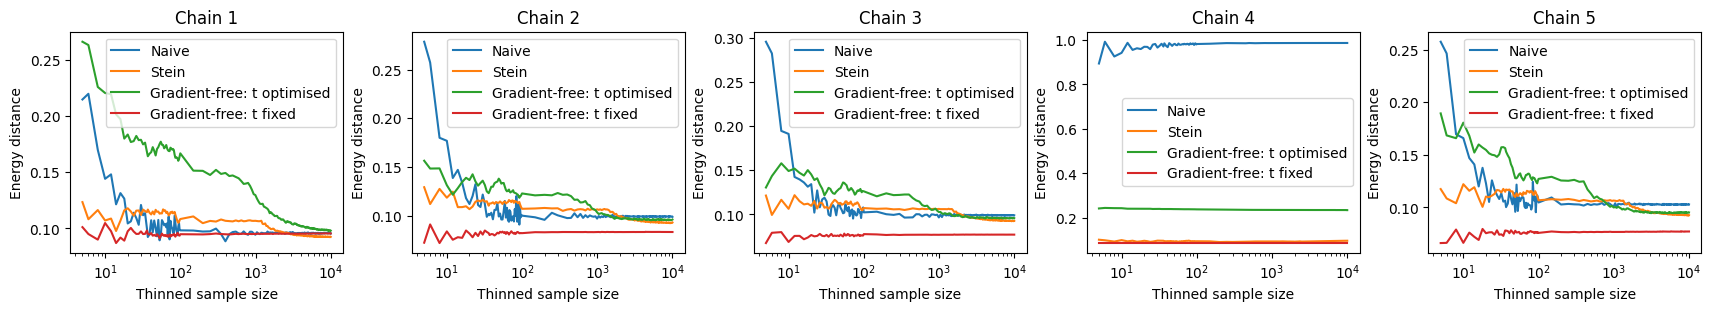

In [169]:
%%time
fig, axs = plt.subplots(1, len(theta_inits), figsize=(17, 3), constrained_layout=True)
for j in range(len(theta_inits)):
    for idx_name, label in indices_to_plot.items():
        res = get_indices(idx_name)(j)
        axs[j].plot(res[:, 0], res[:, 1], label=label);
    axs[j].set_xlabel('Thinned sample size');
    axs[j].set_ylabel('Energy distance');
    axs[j].set_title(f'Chain {j + 1}');
    axs[j].legend();
    axs[j].set_xscale('log');
fig.savefig(figures_path / 'lotka-volterra-gf-thinning-energy-distance.pdf');

Notebook execution took:

In [162]:
time.time() - start_time

375.4640564918518